In [1]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_objective, plot_histogram
from skopt.utils import use_named_args
from skopt.plots import plot_evaluations
from skopt import gp_minimize
from skopt.plots import plot_convergence

from sklearn.datasets import load_diabetes
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

import seaborn as sns
import pandas as pd
import numpy as np
from apyori import apriori
import seaborn as sns; sns.set()

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
abundance_df = pd.read_csv('abundance.csv')

/Users/Dana/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,5,9,20,26,42,47,51,52,59,61,68,76,77,78,79) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
abundance_df.head()

,dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus|t__Enterococcus_gilvus_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis|t__GCF_000415925,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis|t__GCF_000215085,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__GCF_000209855,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1|t__GCF_000478965
0,Candela_Africa,H10,h10,stool,n,40,female,tanzania,Illumina,25981789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Candela_Africa,H11,h11,stool,n,29,female,tanzania,Illumina,25981789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Candela_Africa,H12,h12,stool,n,8,female,tanzania,Illumina,25981789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Candela_Africa,H13,h13,stool,n,34,male,tanzania,Illumina,25981789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Candela_Africa,H14,h14,stool,n,30,male,tanzania,Illumina,25981789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
nonbact = abundance_df.drop(['k__Archaea', 'k__Archaea|p__Euryarchaeota', 'k__Archaea|p__Euryarchaeota|c__Methanobacteria', 'k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales', 'k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae', 'k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter', 'k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii', 'k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii|t__Methanobrevibacter_smithii_unclassified', 'k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_unclassified', 'k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera', 'k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_stadtmanae', 'k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_stadtmanae|t__GCF_000012545', 'k__Bacteria', 'k__Bacteria|p__Acidobacteria', 'k__Bacteria|p__Acidobacteria|c__Acidobacteriia', 'k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales', 'k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae', 'k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Acidobacteriaceae_unclassified', 'k__Bacteria|p__Actinobacteria', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_graevenitzii', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_graevenitzii|t__Actinomyces_graevenitzii_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_odontolyticus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_odontolyticus|t__Actinomyces_odontolyticus_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_turicensis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_turicensis|t__GCF_000296505', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum|s__Varibaculum_cambriense', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum|s__Varibaculum_cambriense|t__GCF_000420065', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia|s__Rothia_mucilaginosa', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia|s__Rothia_mucilaginosa|t__Rothia_mucilaginosa_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia|s__Rothia_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_adolescentis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_adolescentis|t__Bifidobacterium_adolescentis_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_angulatum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_angulatum|t__GCF_000156635', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_bifidum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_bifidum|t__Bifidobacterium_bifidum_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_catenulatum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_catenulatum|t__GCF_000173455', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum|t__Bifidobacterium_longum_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pseudocatenulatum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pseudocatenulatum|t__GCF_000173435', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella|s__Gardnerella_vaginalis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella|s__Gardnerella_vaginalis|t__Gardnerella_vaginalis_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Adlercreutzia', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Adlercreutzia|s__Adlercreutzia_equolifaciens', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Adlercreutzia|s__Adlercreutzia_equolifaciens|t__GCF_000478885', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium|s__Atopobium_parvulum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium|s__Atopobium_parvulum|t__GCF_000024225', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium|s__Atopobium_rimae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium|s__Atopobium_rimae|t__GCF_000174015', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_aerofaciens', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_aerofaciens|t__GCF_000169035', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Coriobacteriaceae_noname', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Coriobacteriaceae_noname|s__Coriobacteriaceae_bacterium_phI', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Coriobacteriaceae_noname|s__Coriobacteriaceae_bacterium_phI|t__GCF_000311845', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella|s__Eggerthella_lenta', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella|s__Eggerthella_lenta|t__GCF_000024265', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella|s__Eggerthella_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Gordonibacter', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Gordonibacter|s__Gordonibacter_pamelaeae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Gordonibacter|s__Gordonibacter_pamelaeae|t__GCF_000210055', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella|s__Olsenella_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Slackia', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Slackia|s__Slackia_piriformis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Slackia|s__Slackia_piriformis|t__GCF_000296445', 'k__Bacteria|p__Bacteroidetes', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_barnesiae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_barnesiae|t__GCF_000374585', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_caccae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_caccae|t__Bacteroides_caccae_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_cellulosilyticus', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_cellulosilyticus|t__Bacteroides_cellulosilyticus_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_clarus', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_clarus|t__GCF_000195615', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_coprocola', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_coprocola|t__GCF_000154845', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_coprophilus', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_coprophilus|t__GCF_000157915', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_dorei', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_dorei|t__Bacteroides_dorei_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_eggerthii', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_eggerthii|t__Bacteroides_eggerthii_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_faecis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_faecis|t__GCF_000226135', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_finegoldii', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_finegoldii|t__Bacteroides_finegoldii_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_fragilis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_fragilis|t__Bacteroides_fragilis_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_intestinalis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_intestinalis|t__GCF_000172175', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_massiliensis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_massiliensis|t__Bacteroides_massiliensis_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_nordii', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_nordii|t__GCF_000273175', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_ovatus', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_ovatus|t__Bacteroides_ovatus_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_plebeius', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_plebeius|t__GCF_000187895', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_salyersiae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_salyersiae|t__Bacteroides_salyersiae_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_4_3_47FAA', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_4_3_47FAA|t__GCF_000158515', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_stercoris', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_stercoris|t__Bacteroides_stercoris_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_thetaiotaomicron', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_thetaiotaomicron|t__Bacteroides_thetaiotaomicron_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_uniformis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_uniformis|t__Bacteroides_uniformis_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_uniformis|t__GCF_000154205', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_vulgatus', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_vulgatus|t__Bacteroides_vulgatus_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_xylanisolvens', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_xylanisolvens|t__Bacteroides_xylanisolvens_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_noname', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_noname|g__Bacteroidales_noname', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_noname|g__Bacteroidales_noname|s__Bacteroidales_bacterium_ph8', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_noname|g__Bacteroidales_noname|s__Bacteroidales_bacterium_ph8|t__GCF_000311925', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Barnesiella', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Barnesiella|s__Barnesiella_intestinihominis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Barnesiella|s__Barnesiella_intestinihominis|t__GCF_000296465', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Coprobacter', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Coprobacter|s__Coprobacter_fastidiosus', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Coprobacter|s__Coprobacter_fastidiosus|t__GCF_000473955', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter|s__Odoribacter_splanchnicus', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter|s__Odoribacter_splanchnicus|t__GCF_000190535', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter|s__Odoribacter_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_distasonis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_distasonis|t__Parabacteroides_distasonis_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_goldsteinii', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_goldsteinii|t__Parabacteroides_goldsteinii_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_merdae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_merdae|t__Parabacteroides_merdae_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_asaccharolytica', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_asaccharolytica|t__Porphyromonas_asaccharolytica_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_bennonis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_bennonis|t__GCF_000375645', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_somerae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_somerae|t__GCF_000372405', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_uenonis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_uenonis|t__GCF_000174775', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella|s__Alloprevotella_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|s__Paraprevotella_clara', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|s__Paraprevotella_clara|t__GCF_000233955', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|s__Paraprevotella_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|s__Paraprevotella_xylaniphila', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella|s__Paraprevotella_xylaniphila|t__GCF_000205165', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_bivia', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_bivia|t__Prevotella_bivia_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_copri', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_copri|t__GCF_000157935', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_disiens', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_disiens|t__Prevotella_disiens_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_stercorea', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_stercorea|t__GCF_000235885', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_timonensis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_timonensis|t__GCF_000177055', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_finegoldii', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_finegoldii|t__GCF_000265365', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_indistinctus', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_indistinctus|t__GCF_000231275', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_onderdonkii', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_onderdonkii|t__GCF_000374505', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_putredinis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_putredinis|t__GCF_000154465', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_senegalensis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_senegalensis|t__GCF_000312145', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_shahii', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_shahii|t__GCF_000210575', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_sp_AP11', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_sp_AP11|t__GCF_000321205', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_unclassified', 'k__Bacteria|p__Cyanobacteria', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Microcoleus', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Microcoleus|s__Microcoleus_unclassified', 'k__Bacteria|p__Firmicutes', 'k__Bacteria|p__Firmicutes|c__Bacilli', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella|s__Granulicatella_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecium', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecium|t__Enterococcus_faecium_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_animalis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_animalis|t__GCF_000183825', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_delbrueckii', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_delbrueckii|t__Lactobacillus_delbrueckii_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_fermentum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_fermentum|t__Lactobacillus_fermentum_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_mucosae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_mucosae|t__GCF_000248095', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_ruminis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_ruminis|t__Lactobacillus_ruminis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_sakei', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_sakei|t__Lactobacillus_sakei_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_lactis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_lactis|t__Leuconostoc_lactis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_pseudomesenteroides', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_pseudomesenteroides|t__Leuconostoc_pseudomesenteroides_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus|s__Lactococcus_lactis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus|s__Lactococcus_lactis|t__Lactococcus_lactis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_anginosus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_anginosus|t__Streptococcus_anginosus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_australis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_australis|t__Streptococcus_australis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_gordonii', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_gordonii|t__GCF_000017005', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_infantarius', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_infantarius|t__Streptococcus_infantarius_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_infantis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_infantis|t__Streptococcus_infantis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_lutetiensis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_lutetiensis|t__GCF_000441535', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_mitis_oralis_pneumoniae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_mitis_oralis_pneumoniae|t__Streptococcus_mitis_oralis_pneumoniae_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_parasanguinis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_parasanguinis|t__Streptococcus_parasanguinis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_salivarius', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_salivarius|t__Streptococcus_salivarius_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_thermophilus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_thermophilus|t__Streptococcus_thermophilus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_vestibularis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_vestibularis|t__Streptococcus_vestibularis_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_asparagiforme', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_asparagiforme|t__GCF_000158075', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_bolteae', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_bolteae|t__Clostridium_bolteae_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_citroniae', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_citroniae|t__GCF_000233455', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_clostridioforme', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_clostridioforme|t__Clostridium_clostridioforme_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_hathewayi', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_hathewayi|t__Clostridium_hathewayi_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_leptum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_leptum|t__GCF_000154345', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_methylpentosum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_methylpentosum|t__GCF_000158655', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_nexile', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_nexile|t__GCF_000156035', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_perfringens', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_perfringens|t__Clostridium_perfringens_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_L2_50', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_L2_50|t__GCF_000154245', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_symbiosum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_symbiosum|t__Clostridium_symbiosum_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_vaginalis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_vaginalis|t__GCF_000163295', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Parvimonas', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Parvimonas|s__Parvimonas_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_duerdenii', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_duerdenii|t__GCF_000146345', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_lacrimalis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_lacrimalis|t__Peptoniphilus_lacrimalis_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Clostridiales_noname', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Clostridiales_noname|s__Bacteroides_pectinophilus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Clostridiales_noname|s__Bacteroides_pectinophilus|t__GCF_000155855', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Clostridiales_noname|s__Clostridiales_bacterium_1_7_47FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Clostridiales_noname|s__Clostridiales_bacterium_1_7_47FAA|t__GCF_000155435', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Clostridiales_noname|s__Clostridiales_genomosp_BVAB3', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Clostridiales_noname|s__Clostridiales_genomosp_BVAB3|t__GCF_000025225', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Flavonifractor', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Flavonifractor|s__Flavonifractor_plautii', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Flavonifractor|s__Flavonifractor_plautii|t__GCF_000239295', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Pseudoflavonifractor', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Pseudoflavonifractor|s__Pseudoflavonifractor_capillosus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Pseudoflavonifractor|s__Pseudoflavonifractor_capillosus|t__GCF_000169255', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_brachy', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_brachy|t__GCF_000488855', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_eligens', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_eligens|t__GCF_000146185', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_hallii', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_hallii|t__GCF_000173975', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_ramulus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_ramulus|t__GCF_000469345', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_rectale', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_rectale|t__Eubacterium_rectale_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_siraeum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_siraeum|t__Eubacterium_siraeum_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_ventriosum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_ventriosum|t__GCF_000153885', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_hadrus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_hadrus|t__GCF_000332875', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_hydrogenotrophica', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_hydrogenotrophica|t__GCF_000157975', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_gnavus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_gnavus|t__Ruminococcus_gnavus_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_obeum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_obeum|t__Ruminococcus_obeum_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_torques', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_torques|t__Ruminococcus_torques_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Butyrivibrio', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Butyrivibrio|s__Butyrivibrio_crossotus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Butyrivibrio|s__Butyrivibrio_crossotus|t__GCF_000156015', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Butyrivibrio|s__Butyrivibrio_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_catus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_catus|t__GCF_000210555', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_comes', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_comes|t__GCF_000155875', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_eutactus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_eutactus|t__GCF_000154425', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_sp_ART55_1', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_sp_ART55_1|t__GCF_000210595', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_formicigenerans', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_formicigenerans|t__Dorea_formicigenerans_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_longicatena', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_longicatena|t__GCF_000154065', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_1_1_57FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_1_1_57FAA|t__GCF_000218445', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_1_4_56FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_1_4_56FAA|t__GCF_000218385', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_2_1_58FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_2_1_58FAA|t__GCF_000218465', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_3_1_46FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_3_1_46FAA|t__GCF_000209405', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_3_1_57FAA_CT1', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_3_1_57FAA_CT1|t__GCF_000218405', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_4_1_37FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_4_1_37FAA|t__GCF_000191805', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_5_1_63FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_5_1_63FAA|t__GCF_000185525', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_7_1_58FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_7_1_58FAA|t__GCF_000242155', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_8_1_57FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_8_1_57FAA|t__GCF_000185545', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_9_1_43BFAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_9_1_43BFAA|t__GCF_000209445', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_hominis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_hominis|t__GCF_000225345', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_intestinalis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_intestinalis|t__Roseburia_intestinalis_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_inulinivorans', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_inulinivorans|t__GCF_000174195', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Clostridium_bartlettii', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Clostridium_bartlettii|t__GCF_000154445', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Peptostreptococcaceae_noname_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcus|s__Peptostreptococcus_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaerotruncus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaerotruncus|s__Anaerotruncus_colihominis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaerotruncus|s__Anaerotruncus_colihominis|t__GCF_000154565', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaerotruncus|s__Anaerotruncus_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__Faecalibacterium_prausnitzii_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__GCF_000162015', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__GCF_000166035', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcaceae_noname', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcaceae_noname|s__Ruminococcaceae_bacterium_D16', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcaceae_noname|s__Ruminococcaceae_bacterium_D16|t__GCF_000177015', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_albus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_albus|t__Ruminococcus_albus_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_bromii', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_bromii|t__GCF_000209875', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_callidus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_callidus|t__GCF_000468015', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_champanellensis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_champanellensis|t__GCF_000210095', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_flavefaciens', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_flavefaciens|t__Ruminococcus_flavefaciens_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_lactaris', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_lactaris|t__Ruminococcus_lactaris_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_sp_5_1_39BFAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_sp_5_1_39BFAA|t__GCF_000159975', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Subdoligranulum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Subdoligranulum|s__Subdoligranulum_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Subdoligranulum|s__Subdoligranulum_variabile', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Subdoligranulum|s__Subdoligranulum_variabile|t__GCF_000157955', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Catenibacterium', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Catenibacterium|s__Catenibacterium_mitsuokai', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Catenibacterium|s__Catenibacterium_mitsuokai|t__GCF_000173795', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Coprobacillus', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Coprobacillus|s__Coprobacillus_sp_29_1', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Coprobacillus|s__Coprobacillus_sp_29_1|t__GCF_000186525', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Coprobacillus|s__Coprobacillus_sp_D6', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Coprobacillus|s__Coprobacillus_sp_D6|t__GCF_000269565', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Clostridium_innocuum', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Clostridium_innocuum|t__GCF_000371425', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Erysipelotrichaceae_bacterium_2_2_44A', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Erysipelotrichaceae_bacterium_2_2_44A|t__GCF_000225685', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Erysipelotrichaceae_bacterium_6_1_45', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Erysipelotrichaceae_bacterium_6_1_45|t__GCF_000242175', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Eubacterium_biforme', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Eubacterium_biforme|t__GCF_000156655', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Eubacterium_cylindroides', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Eubacterium_cylindroides|t__GCF_000469305', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Holdemania', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Holdemania|s__Holdemania_filiformis', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Holdemania|s__Holdemania_filiformis|t__GCF_000157995', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Solobacterium', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Solobacterium|s__Solobacterium_moorei', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Solobacterium|s__Solobacterium_moorei|t__GCF_000186945', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Turicibacter', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Turicibacter|s__Turicibacter_sanguinis', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Turicibacter|s__Turicibacter_sanguinis|t__GCF_000178255', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Turicibacter|s__Turicibacter_unclassified', 'k__Bacteria|p__Firmicutes|c__Negativicutes', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcaceae_unclassified', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_fermentans', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_fermentans|t__GCF_000025305', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_intestini', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_intestini|t__GCF_000230275', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_sp_D21', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_sp_D21|t__GCF_000174215', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_unclassified', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Phascolarctobacterium', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Phascolarctobacterium|s__Phascolarctobacterium_succinatutens', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Phascolarctobacterium|s__Phascolarctobacterium_succinatutens|t__GCF_000188175', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Dialister', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Dialister|s__Dialister_invisus', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Dialister|s__Dialister_invisus|t__GCF_000160055', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Dialister|s__Dialister_micraerophilus', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Dialister|s__Dialister_micraerophilus|t__Dialister_micraerophilus_unclassified', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Dialister|s__Dialister_succinatiphilus', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Dialister|s__Dialister_succinatiphilus|t__GCF_000242435', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_unclassified', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Mitsuokella', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Mitsuokella|s__Mitsuokella_multacida', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Mitsuokella|s__Mitsuokella_multacida|t__GCF_000155955', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Mitsuokella|s__Mitsuokella_unclassified', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_atypica', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_atypica|t__Veillonella_atypica_unclassified', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_dispar', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_dispar|t__GCF_000160015', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_parvula', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_parvula|t__Veillonella_parvula_unclassified', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_unclassified', 'k__Bacteria|p__Fusobacteria', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_gonidiaformans', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_gonidiaformans|t__Fusobacterium_gonidiaformans_unclassified', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_nucleatum', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_nucleatum|t__Fusobacterium_nucleatum_unclassified', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichiaceae_unclassified', 'k__Bacteria|p__Proteobacteria', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiales_noname', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiales_noname|g__Burkholderiales_noname', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiales_noname|g__Burkholderiales_noname|s__Burkholderiales_bacterium_1_1_47', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiales_noname|g__Burkholderiales_noname|s__Burkholderiales_bacterium_1_1_47|t__GCF_000144975', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Oxalobacter', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Oxalobacter|s__Oxalobacter_formigenes', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Oxalobacter|s__Oxalobacter_formigenes|t__GCF_000158495', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Oxalobacter|s__Oxalobacter_formigenes|t__Oxalobacter_formigenes_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Parasutterella', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Parasutterella|s__Parasutterella_excrementihominis', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Parasutterella|s__Parasutterella_excrementihominis|t__GCF_000205025', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterellaceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_wadsworthensis', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_wadsworthensis|t__GCF_000411515', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_wadsworthensis|t__Sutterella_wadsworthensis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_flavescens', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_flavescens|t__Neisseria_flavescens_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_unclassified', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila|s__Bilophila_unclassified', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila|s__Bilophila_wadsworthia', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila|s__Bilophila_wadsworthia|t__GCF_000185705', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_desulfuricans', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_desulfuricans|t__Desulfovibrio_desulfuricans_unclassified', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_piger', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_piger|t__GCF_000156375', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_jejuni', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_jejuni|t__Campylobacter_jejuni_unclassified', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_pylori', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_pylori|t__Helicobacter_pylori_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Succinivibrionaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Succinivibrionaceae|g__Succinivibrionaceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Citrobacter', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_freundii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_freundii|t__Citrobacter_freundii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_aerogenes', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_aerogenes|t__Enterobacter_aerogenes_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_cloacae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_cloacae|t__Enterobacter_cloacae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli|t__Escherichia_coli_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_pneumoniae|t__Klebsiella_pneumoniae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Providencia', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Providencia|s__Providencia_alcalifaciens', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Providencia|s__Providencia_alcalifaciens|t__Providencia_alcalifaciens_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter|s__Aggregatibacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parainfluenzae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parainfluenzae|t__Haemophilus_parainfluenzae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_pittmaniae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_pittmaniae|t__GCF_000223275', 'k__Bacteria|p__Spirochaetes', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Brachyspiraceae', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Brachyspiraceae|g__Brachyspira', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Brachyspiraceae|g__Brachyspira|s__Brachyspira_pilosicoli', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Brachyspiraceae|g__Brachyspira|s__Brachyspira_pilosicoli|t__Brachyspira_pilosicoli_unclassified', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Brachyspiraceae|g__Brachyspira|s__Brachyspira_unclassified', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_succinifaciens', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_succinifaciens|t__GCF_000195275', 'k__Bacteria|p__Tenericutes', 'k__Bacteria|p__Tenericutes|c__Mollicutes', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_hominis', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_hominis|t__Mycoplasma_hominis_unclassified', 'k__Bacteria|p__Verrucomicrobia', 'k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae', 'k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales', 'k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae', 'k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|g__Akkermansia', 'k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|g__Akkermansia|s__Akkermansia_muciniphila', 'k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|g__Akkermansia|s__Akkermansia_muciniphila|t__GCF_000020225', 'k__Eukaryota', 'k__Eukaryota|p__Eukaryota_noname', 'k__Eukaryota|p__Eukaryota_noname|c__Eukaryota_noname', 'k__Eukaryota|p__Eukaryota_noname|c__Eukaryota_noname|o__Eukaryota_noname', 'k__Eukaryota|p__Eukaryota_noname|c__Eukaryota_noname|o__Eukaryota_noname|f__Eukaryota_noname', 'k__Eukaryota|p__Eukaryota_noname|c__Eukaryota_noname|o__Eukaryota_noname|f__Eukaryota_noname|g__Entamoeba', 'k__Eukaryota|p__Eukaryota_noname|c__Eukaryota_noname|o__Eukaryota_noname|f__Eukaryota_noname|g__Entamoeba|s__Entamoeba_dispar', 'k__Eukaryota|p__Eukaryota_noname|c__Eukaryota_noname|o__Eukaryota_noname|f__Eukaryota_noname|g__Entamoeba|s__Entamoeba_dispar|t__GCA_000209125', 'k__Eukaryota|p__Microsporidia', 'k__Eukaryota|p__Microsporidia|c__Microsporidia_noname', 'k__Eukaryota|p__Microsporidia|c__Microsporidia_noname|o__Microsporidia_noname', 'k__Eukaryota|p__Microsporidia|c__Microsporidia_noname|o__Microsporidia_noname|f__Enterocytozoonidae', 'k__Eukaryota|p__Microsporidia|c__Microsporidia_noname|o__Microsporidia_noname|f__Enterocytozoonidae|g__Enterocytozoon', 'k__Eukaryota|p__Microsporidia|c__Microsporidia_noname|o__Microsporidia_noname|f__Enterocytozoonidae|g__Enterocytozoon|s__Enterocytozoon_bieneusi', 'k__Eukaryota|p__Microsporidia|c__Microsporidia_noname|o__Microsporidia_noname|f__Enterocytozoonidae|g__Enterocytozoon|s__Enterocytozoon_bieneusi|t__GCA_000209485', 'k__Archaea|p__Euryarchaeota|c__Archaeoglobi', 'k__Archaea|p__Euryarchaeota|c__Archaeoglobi|o__Archaeoglobales', 'k__Archaea|p__Euryarchaeota|c__Archaeoglobi|o__Archaeoglobales|f__Archaeoglobaceae', 'k__Archaea|p__Euryarchaeota|c__Archaeoglobi|o__Archaeoglobales|f__Archaeoglobaceae|g__Archaeoglobaceae_unclassified', 'k__Archaea|p__Euryarchaeota|c__Methanococci', 'k__Archaea|p__Euryarchaeota|c__Methanococci|o__Methanococcales', 'k__Archaea|p__Euryarchaeota|c__Methanococci|o__Methanococcales|f__Methanocaldococcaceae', 'k__Archaea|p__Euryarchaeota|c__Methanococci|o__Methanococcales|f__Methanocaldococcaceae|g__Methanocaldococcaceae_unclassified', 'k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella', 'k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella|s__Granulicella_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetales_noname', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetales_noname|g__Tropheryma', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetales_noname|g__Tropheryma|s__Tropheryma_whipplei', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetales_noname|g__Tropheryma|s__Tropheryma_whipplei|t__Tropheryma_whipplei_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Brevibacteriaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Brevibacteriaceae|g__Brevibacterium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_linens', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_linens|t__GCF_000167575', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_crenatum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_crenatum|t__GCF_000380545', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermatophilaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermatophilaceae|g__Dermatophilaceae_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia|s__Rothia_dentocariosa', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia|s__Rothia_dentocariosa|t__Rothia_dentocariosa_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacteriaceae_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_freudenreichii', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_freudenreichii|t__GCF_000091725', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Alloscardovia', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Alloscardovia|s__Alloscardovia_omnicolens', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Alloscardovia|s__Alloscardovia_omnicolens|t__Alloscardovia_omnicolens_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_animalis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_animalis|t__Bifidobacterium_animalis_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_breve', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_breve|t__Bifidobacterium_breve_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_dentium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_dentium|t__Bifidobacterium_dentium_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum|t__GCF_000497735', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Parascardovia', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Parascardovia|s__Parascardovia_denticolens', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Parascardovia|s__Parascardovia_denticolens|t__Parascardovia_denticolens_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Scardovia', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Scardovia|s__Scardovia_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Scardovia|s__Scardovia_wiggsiae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Scardovia|s__Scardovia_wiggsiae|t__Scardovia_wiggsiae_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium|s__Atopobium_vaginae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium|s__Atopobium_vaginae|t__Atopobium_vaginae_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_intestinalis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_intestinalis|t__GCF_000156175', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_stercoris', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_stercoris|t__GCF_000156215', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_tanakaei', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_tanakaei|t__GCF_000225705', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella|s__Eggerthella_sp_1_3_56FAA', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella|s__Eggerthella_sp_1_3_56FAA|t__GCF_000185625', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Enterorhabdus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Enterorhabdus|s__Enterorhabdus_caecimuris', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Enterorhabdus|s__Enterorhabdus_caecimuris|t__GCF_000403355', 'k__Bacteria|p__Aquificae', 'k__Bacteria|p__Aquificae|c__Aquificae', 'k__Bacteria|p__Aquificae|c__Aquificae|o__Aquificales', 'k__Bacteria|p__Aquificae|c__Aquificae|o__Aquificales|f__Desulfurobacteriaceae', 'k__Bacteria|p__Aquificae|c__Aquificae|o__Aquificales|f__Desulfurobacteriaceae|g__Desulfurobacteriaceae_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_cellulosilyticus|t__GCF_000158035', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_eggerthii|t__GCF_000155815', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_finegoldii|t__GCF_000156195', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_fluxus', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_fluxus|t__GCF_000195635', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_fragilis|t__GCF_000025985', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_fragilis|t__GCF_000297735', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_gallinarum', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_gallinarum|t__GCF_000374365', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_oleiciplenus', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_oleiciplenus|t__GCF_000315485', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_ovatus|t__GCF_000218325', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_ovatus|t__GCF_000273215', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_salanitronis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_salanitronis|t__GCF_000190575', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_salyersiae|t__GCF_000273235', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_1_1_14', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_1_1_14|t__GCF_000162515', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_1_1_30', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_1_1_30|t__GCF_000218365', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_1_1_6', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_1_1_6|t__GCF_000159875', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_1_22', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_1_22|t__GCF_000162155', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_1_56FAA', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_1_56FAA|t__GCF_000218345', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_3_1_19', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_3_1_19|t__GCF_000163655', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_3_1_23', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_3_1_23|t__GCF_000162555', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_3_2_5', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_3_2_5|t__GCF_000159855', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_9_1_42FAA', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_9_1_42FAA|t__GCF_000157075', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_thetaiotaomicron|t__GCF_000011065', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_xylanisolvens|t__GCF_000210075', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Marinilabiliaceae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Marinilabiliaceae|g__Marinilabiliaceae_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Butyricimonas', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Butyricimonas|s__Butyricimonas_synergistica', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Butyricimonas|s__Butyricimonas_synergistica|t__GCF_000379665', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Dysgonomonas', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Dysgonomonas|s__Dysgonomonas_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter|s__Odoribacter_laneus', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter|s__Odoribacter_laneus|t__GCF_000243215', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_johnsonii', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_johnsonii|t__Parabacteroides_johnsonii_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_merdae|t__GCF_000307345', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_sp_D13', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_sp_D13|t__GCF_000162275', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_buccae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_buccae|t__Prevotella_buccae_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_buccalis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_buccalis|t__GCF_000177075', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_intermedia', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_intermedia|t__GCF_000261025', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_melaninogenica', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_melaninogenica|t__Prevotella_melaninogenica_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_multisaccharivorax', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_multisaccharivorax|t__GCF_000218235', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_oralis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_oralis|t__Prevotella_oralis_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_sp_HGB5', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_sp_HGB5|t__GCF_000183485', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Cellulophaga', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Cellulophaga|s__Cellulophaga_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Riemerella', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Riemerella|s__Riemerella_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Pedobacter', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Pedobacter|s__Pedobacter_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Sphingobacterium', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Sphingobacterium|s__Sphingobacterium_unclassified', 'k__Bacteria|p__Candidatus_Saccharibacteria', 'k__Bacteria|p__Candidatus_Saccharibacteria|c__Candidatus_Saccharibacteria_noname', 'k__Bacteria|p__Candidatus_Saccharibacteria|c__Candidatus_Saccharibacteria_noname|o__Candidatus_Saccharibacteria_noname', 'k__Bacteria|p__Candidatus_Saccharibacteria|c__Candidatus_Saccharibacteria_noname|o__Candidatus_Saccharibacteria_noname|f__Candidatus_Saccharibacteria_noname', 'k__Bacteria|p__Candidatus_Saccharibacteria|c__Candidatus_Saccharibacteria_noname|o__Candidatus_Saccharibacteria_noname|f__Candidatus_Saccharibacteria_noname|g__Candidatus_Saccharibacteria_noname', 'k__Bacteria|p__Candidatus_Saccharibacteria|c__Candidatus_Saccharibacteria_noname|o__Candidatus_Saccharibacteria_noname|f__Candidatus_Saccharibacteria_noname|g__Candidatus_Saccharibacteria_noname_unclassified', 'k__Bacteria|p__Candidatus_Saccharibacteria|c__Candidatus_Saccharibacteria_noname|o__Candidatus_Saccharibacteria_noname|f__Candidatus_Saccharibacteria_noname|g__Candidatus_Saccharibacteria_noname|s__candidate_division_TM7_single_cell_isolate_TM7b', 'k__Bacteria|p__Candidatus_Saccharibacteria|c__Candidatus_Saccharibacteria_noname|o__Candidatus_Saccharibacteria_noname|f__Candidatus_Saccharibacteria_noname|g__Candidatus_Saccharibacteria_noname|s__candidate_division_TM7_single_cell_isolate_TM7b|t__GCF_000170655', 'k__Bacteria|p__Candidatus_Saccharibacteria|c__Candidatus_Saccharibacteria_noname|o__Candidatus_Saccharibacteria_noname|f__Candidatus_Saccharibacteria_noname|g__Candidatus_Saccharibacteria_noname|s__candidate_division_TM7_single_cell_isolate_TM7c', 'k__Bacteria|p__Candidatus_Saccharibacteria|c__Candidatus_Saccharibacteria_noname|o__Candidatus_Saccharibacteria_noname|f__Candidatus_Saccharibacteria_noname|g__Candidatus_Saccharibacteria_noname|s__candidate_division_TM7_single_cell_isolate_TM7c|t__GCF_000170675', 'k__Bacteria|p__Chlamydiae', 'k__Bacteria|p__Chlamydiae|c__Chlamydiia', 'k__Bacteria|p__Chlamydiae|c__Chlamydiia|o__Chlamydiales', 'k__Bacteria|p__Chlamydiae|c__Chlamydiia|o__Chlamydiales|f__Chlamydiaceae', 'k__Bacteria|p__Chlamydiae|c__Chlamydiia|o__Chlamydiales|f__Chlamydiaceae|g__Chlamydophila', 'k__Bacteria|p__Chlamydiae|c__Chlamydiia|o__Chlamydiales|f__Chlamydiaceae|g__Chlamydophila|s__Chlamydophila_unclassified', 'k__Bacteria|p__Chlorobi', 'k__Bacteria|p__Chlorobi|c__Chlorobia', 'k__Bacteria|p__Chlorobi|c__Chlorobia|o__Chlorobiales', 'k__Bacteria|p__Chlorobi|c__Chlorobia|o__Chlorobiales|f__Chlorobiaceae', 'k__Bacteria|p__Chlorobi|c__Chlorobia|o__Chlorobiales|f__Chlorobiaceae|g__Chlorobium', 'k__Bacteria|p__Chlorobi|c__Chlorobia|o__Chlorobiales|f__Chlorobiaceae|g__Chlorobium|s__Chlorobium_phaeobacteroides', 'k__Bacteria|p__Chlorobi|c__Chlorobia|o__Chlorobiales|f__Chlorobiaceae|g__Chlorobium|s__Chlorobium_phaeobacteroides|t__Chlorobium_phaeobacteroides_unclassified', 'k__Bacteria|p__Deferribacteres', 'k__Bacteria|p__Deferribacteres|c__Deferribacteres', 'k__Bacteria|p__Deferribacteres|c__Deferribacteres|o__Deferribacterales', 'k__Bacteria|p__Deferribacteres|c__Deferribacteres|o__Deferribacterales|f__Deferribacteraceae', 'k__Bacteria|p__Deferribacteres|c__Deferribacteres|o__Deferribacterales|f__Deferribacteraceae|g__Mucispirillum', 'k__Bacteria|p__Deferribacteres|c__Deferribacteres|o__Deferribacterales|f__Deferribacteraceae|g__Mucispirillum|s__Mucispirillum_schaedleri', 'k__Bacteria|p__Deferribacteres|c__Deferribacteres|o__Deferribacterales|f__Deferribacteraceae|g__Mucispirillum|s__Mucispirillum_schaedleri|t__GCF_000487995', 'k__Bacteria|p__Deinococcus_Thermus', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcaceae', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcaceae|g__Deinococcus', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcaceae|g__Deinococcus|s__Deinococcus_unclassified', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Thermus', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Thermus|s__Thermus_scotoductus', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Thermus|s__Thermus_scotoductus|t__Thermus_scotoductus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Alicyclobacillaceae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Alicyclobacillaceae|g__Alicyclobacillus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Alicyclobacillaceae|g__Alicyclobacillus|s__Alicyclobacillus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Gemella', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Gemella|s__Gemella_haemolysans', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Gemella|s__Gemella_haemolysans|t__Gemella_haemolysans_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Gemella|s__Gemella_morbillorum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Gemella|s__Gemella_morbillorum|t__GCF_000185645', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Gemella|s__Gemella_sanguinis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Gemella|s__Gemella_sanguinis|t__GCF_000204335', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Gemella|s__Gemella_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_aureus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_aureus|t__Staphylococcus_aureus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Abiotrophia', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Abiotrophia|s__Abiotrophia_defectiva', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Abiotrophia|s__Abiotrophia_defectiva|t__GCF_000160075', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella|s__Granulicatella_adiacens', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella|s__Granulicatella_adiacens|t__GCF_000160675', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_casseliflavus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_casseliflavus|t__Enterococcus_casseliflavus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_durans', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_durans|t__Enterococcus_durans_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecalis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecalis|t__Enterococcus_faecalis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_hirae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_hirae|t__Enterococcus_hirae_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_acidophilus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_acidophilus|t__Lactobacillus_acidophilus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_casei_paracasei', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_casei_paracasei|t__Lactobacillus_casei_paracasei_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_crispatus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_crispatus|t__Lactobacillus_crispatus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_curvatus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_curvatus|t__GCF_000235705', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_fructivorans', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_fructivorans|t__GCF_000185465', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_gasseri', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_gasseri|t__Lactobacillus_gasseri_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_gastricus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_gastricus|t__GCF_000247775', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_plantarum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_plantarum|t__Lactobacillus_plantarum_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_reuteri', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_reuteri|t__Lactobacillus_reuteri_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_rhamnosus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_rhamnosus|t__Lactobacillus_rhamnosus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_salivarius', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_salivarius|t__Lactobacillus_salivarius_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_sanfranciscensis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_sanfranciscensis|t__GCF_000225325', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_versmoldensis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_versmoldensis|t__GCF_000260455', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_pentosaceus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_pentosaceus|t__Pediococcus_pentosaceus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_citreum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_citreum|t__Leuconostoc_citreum_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_kimchii', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_kimchii|t__GCF_000092505', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_mesenteroides', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_mesenteroides|t__Leuconostoc_mesenteroides_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_cibaria', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_cibaria|t__GCF_000193635', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_confusa', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_confusa|t__GCF_000239955', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus|s__Lactococcus_garvieae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus|s__Lactococcus_garvieae|t__Lactococcus_garvieae_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus|s__Lactococcus_raffinolactis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus|s__Lactococcus_raffinolactis|t__GCF_000327305', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_agalactiae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_agalactiae|t__Streptococcus_agalactiae_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_constellatus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_constellatus|t__Streptococcus_constellatus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_cristatus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_cristatus|t__Streptococcus_cristatus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_gallolyticus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_gallolyticus|t__Streptococcus_gallolyticus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_mutans', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_mutans|t__Streptococcus_mutans_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_oligofermentans', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_oligofermentans|t__GCF_000385925', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sanguinis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sanguinis|t__Streptococcus_sanguinis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sobrinus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sobrinus|t__Streptococcus_sobrinus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_tigurinus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_tigurinus|t__Streptococcus_tigurinus_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Butyricicoccus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Butyricicoccus|s__Butyricicoccus_pullicaecorum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Butyricicoccus|s__Butyricicoccus_pullicaecorum|t__GCF_000398925', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridiaceae_noname', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridiaceae_noname|s__Clostridiaceae_bacterium_JC118', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridiaceae_noname|s__Clostridiaceae_bacterium_JC118|t__GCF_000313565', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_bolteae|t__GCF_000154365', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_bolteae|t__GCF_000371665', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_butyricum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_butyricum|t__Clostridium_butyricum_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_celatum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_celatum|t__GCF_000320405', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_clostridioforme|t__GCF_000371525', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_hathewayi|t__GCF_000160095', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_hathewayi|t__GCF_000371445', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_saccharolyticum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_saccharolyticum|t__GCF_000210535', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_scindens', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_scindens|t__GCF_000154505', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_ATCC_BAA_442', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_ATCC_BAA_442|t__GCF_000466445', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_D5', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_D5|t__GCF_000190355', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_KLE_1755', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_KLE_1755|t__GCF_000466465', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_M62_1', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_M62_1|t__GCF_000159055', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Clostridiales_Family_XIII_Incertae_Sedis_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_lactolyticus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_lactolyticus|t__GCF_000156575', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_prevotii', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_prevotii|t__Anaerococcus_prevotii_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Clostridiales_Family_XI_Incertae_Sedis_noname', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Clostridiales_Family_XI_Incertae_Sedis_noname|s__Clostridiales_bacterium_BV3C26', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Clostridiales_Family_XI_Incertae_Sedis_noname|s__Clostridiales_bacterium_BV3C26|t__GCF_000478985', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Finegoldia', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Finegoldia|s__Finegoldia_magna', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Finegoldia|s__Finegoldia_magna|t__Finegoldia_magna_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Parvimonas|s__Parvimonas_micra', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Parvimonas|s__Parvimonas_micra|t__GCF_000154405', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_harei', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_harei|t__GCF_000183565', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Anaerofustis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Anaerofustis|s__Anaerofustis_stercorihominis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Anaerofustis|s__Anaerofustis_stercorihominis|t__GCF_000154825', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_limosum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_limosum|t__GCF_000152245', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_rectale|t__GCF_000020605', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_saphenum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_saphenum|t__GCF_000161975', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_siraeum|t__GCF_000209915', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_3_1_31', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_3_1_31|t__Eubacterium_sp_3_1_31_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_caccae', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_caccae|t__GCF_000154305', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_hansenii', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_hansenii|t__GCF_000156675', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_producta', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_producta|t__GCF_000373885', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_obeum|t__GCF_000153905', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_obeum|t__GCF_000210015', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Ruminococcus_torques|t__GCF_000210035', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_formicigenerans|t__GCF_000225745', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoanaerobaculum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoanaerobaculum|s__Lachnoanaerobaculum_saburreum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoanaerobaculum|s__Lachnoanaerobaculum_saburreum|t__Lachnoanaerobaculum_saburreum_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_5_1_57FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_5_1_57FAA|t__GCF_000218425', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_6_1_63FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_6_1_63FAA|t__GCF_000209425', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_ICM7', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_ICM7|t__GCF_000287675', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_oral_taxon_082', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_oral_taxon_082|t__GCF_000242315', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Marvinbryantia', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Marvinbryantia|s__Marvinbryantia_formatexigens', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Marvinbryantia|s__Marvinbryantia_formatexigens|t__GCF_000173815', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sinus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sinus|t__GCF_000160635', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_intestinalis|t__GCF_000209995', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Stomatobaculum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Stomatobaculum|s__Stomatobaculum_longum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Stomatobaculum|s__Stomatobaculum_longum|t__GCF_000242235', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_sp_KLE_1728', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_sp_KLE_1728|t__GCF_000469425', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_sp_KLE_1745', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_sp_KLE_1745|t__GCF_000469445', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_valericigenes', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter|s__Oscillibacter_valericigenes|t__GCF_000283575', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Clostridium_glycolicum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Clostridium_glycolicum|t__GCF_000373865', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcus|s__Peptostreptococcus_stomatis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcus|s__Peptostreptococcus_stomatis|t__GCF_000147675', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__GCF_000210735', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_lactaris|t__GCF_000155205', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_lactaris|t__GCF_000507785', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_sp', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_sp_JC304', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_sp_JC304|t__GCF_000285855', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_sp|t__GCF_000209835', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Subdoligranulum|s__Subdoligranulum_sp_4_3_54A2FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Subdoligranulum|s__Subdoligranulum_sp_4_3_54A2FAA|t__GCF_000238635', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Halanaerobiales', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Halanaerobiales|f__Halobacteroidaceae', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Halanaerobiales|f__Halobacteroidaceae|g__Halobacteroidaceae_unclassified', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Allobaculum', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Allobaculum|s__Allobaculum_stercoricanis', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Allobaculum|s__Allobaculum_stercoricanis|t__GCF_000384195', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Bulleidia', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Bulleidia|s__Bulleidia_extructa', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Bulleidia|s__Bulleidia_extructa|t__GCF_000177375', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Coprobacillus|s__Coprobacillus_unclassified', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Eggerthia', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Eggerthia|s__Eggerthia_catenaformis', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Eggerthia|s__Eggerthia_catenaformis|t__GCF_000340375', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Clostridium_ramosum', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Clostridium_ramosum|t__GCF_000154485', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Clostridium_spiroforme', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Clostridium_spiroforme|t__GCF_000154805', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Erysipelotrichaceae_bacterium_21_3', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Erysipelotrichaceae_bacterium_21_3|t__GCF_000242195', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Erysipelotrichaceae_bacterium_3_1_53', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Erysipelotrichaceae_bacterium_3_1_53|t__GCF_000165065', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Erysipelotrichaceae_bacterium_5_2_54FAA', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Erysipelotrichaceae_bacterium_5_2_54FAA|t__GCF_000163515', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Eubacterium_dolichum', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname|s__Eubacterium_dolichum|t__GCF_000154285', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Holdemania|s__Holdemania_sp_AP2', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Holdemania|s__Holdemania_sp_AP2|t__GCF_000327285', 'k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Holdemania|s__Holdemania_unclassified', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_sp_BV3L6', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_sp_BV3L6|t__GCF_000468835', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Anaeroglobus', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Anaeroglobus|s__Anaeroglobus_geminatus', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Anaeroglobus|s__Anaeroglobus_geminatus|t__GCF_000239275', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megamonas', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megamonas|s__Megamonas_funiformis', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megamonas|s__Megamonas_funiformis|t__GCF_000245775', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megamonas|s__Megamonas_hypermegale', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megamonas|s__Megamonas_hypermegale|t__GCF_000209975', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megamonas|s__Megamonas_rupellensis', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megamonas|s__Megamonas_rupellensis|t__GCF_000378365', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megamonas|s__Megamonas_unclassified', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_elsdenii', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_elsdenii|t__GCF_000283495', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_micronuciformis', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_micronuciformis|t__GCF_000165735', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_bovis', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_bovis|t__GCF_000381005', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_3_1_44', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_3_1_44|t__GCF_000163715', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_6_1_27', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_6_1_27|t__GCF_000163735', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_mortiferum', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_mortiferum|t__GCF_000158195', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_periodonticum', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_periodonticum|t__Fusobacterium_periodonticum_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Asticcacaulis', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Asticcacaulis|s__Asticcacaulis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Caulobacter', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Caulobacter|s__Caulobacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bartonellaceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bartonellaceae|g__Bartonella', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bartonellaceae|g__Bartonella|s__Bartonella_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Bordetella', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Bordetella|s__Bordetella_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Burkholderia', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Burkholderia|s__Burkholderia_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Cupriavidus', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Cupriavidus|s__Cupriavidus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Lautropia', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Lautropia|s__Lautropia_mirabilis', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Lautropia|s__Lautropia_mirabilis|t__GCF_000186425', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Comamonas', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Comamonas|s__Comamonas_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Candidatus_Zinderia', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Candidatus_Zinderia|s__Candidatus_Zinderia_insecticola', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Candidatus_Zinderia|s__Candidatus_Zinderia_insecticola|t__GCF_000147015', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Oxalobacter|s__Oxalobacter_formigenes|t__GCF_000158475', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_wadsworthensis|t__GCF_000186505', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_wadsworthensis|t__GCF_000297775', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Gallionellales', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Gallionellales|f__Gallionellaceae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Gallionellales|f__Gallionellaceae|g__Gallionellaceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Chromobacterium', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Chromobacterium|s__Chromobacterium_unclassified', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_desulfuricans|t__GCF_000420465', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_termitidis', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_termitidis|t__GCF_000504305', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Arcobacter', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Arcobacter|s__Arcobacter_butzleri', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Arcobacter|s__Arcobacter_butzleri|t__Arcobacter_butzleri_unclassified', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Arcobacter|s__Arcobacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_concisus', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_concisus|t__GCF_000017725', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_hominis', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_hominis|t__GCF_000017585', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Succinivibrionaceae|g__Succinatimonas', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Succinivibrionaceae|g__Succinatimonas|s__Succinatimonas_hippei', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Succinivibrionaceae|g__Succinatimonas|s__Succinatimonas_hippei|t__GCF_000188195', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Pseudoalteromonadaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Pseudoalteromonadaceae|g__Pseudoalteromonadaceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Spiribacter', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Spiribacter|s__Spiribacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_koseri', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Citrobacter|s__Citrobacter_koseri|t__GCF_000018045', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacteriaceae_noname', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacteriaceae_noname|s__Enterobacteriaceae_bacterium_9_2_54FAA', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacteriaceae_noname|s__Enterobacteriaceae_bacterium_9_2_54FAA|t__GCF_000185685', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_cancerogenus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_cancerogenus|t__GCF_000155995', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_hormaechei', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_hormaechei|t__Enterobacter_hormaechei_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_mori', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_mori|t__GCF_000211415', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Hafnia', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Hafnia|s__Hafnia_alvei', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Hafnia|s__Hafnia_alvei|t__GCF_000239255', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_oxytoca', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_oxytoca|t__Klebsiella_oxytoca_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pantoea', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pantoea|s__Pantoea_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Proteus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Proteus|s__Proteus_mirabilis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Proteus|s__Proteus_mirabilis|t__Proteus_mirabilis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Proteus|s__Proteus_penneri', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Proteus|s__Proteus_penneri|t__GCF_000155835', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Proteus|s__Proteus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Providencia|s__Providencia_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Raoultella', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Raoultella|s__Raoultella_ornithinolytica', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Raoultella|s__Raoultella_ornithinolytica|t__GCF_000367425', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Shigella', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Shigella|s__Shigella_flexneri', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Shigella|s__Shigella_flexneri|t__Shigella_flexneri_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Shigella|s__Shigella_sonnei', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Shigella|s__Shigella_sonnei|t__Shigella_sonnei_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Yersinia', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Yersinia|s__Yersinia_pestis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Yersinia|s__Yersinia_pestis|t__Yersinia_pestis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Yersinia|s__Yersinia_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Hahellaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Hahellaceae|g__Hahellaceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae|g__Halomonas', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae|g__Halomonas|s__Halomonas_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Actinobacillus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Actinobacillus|s__Actinobacillus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter|s__Aggregatibacter_aphrophilus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter|s__Aggregatibacter_aphrophilus|t__Aggregatibacter_aphrophilus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter|s__Aggregatibacter_segnis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter|s__Aggregatibacter_segnis|t__GCF_000185305', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_haemolyticus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_haemolyticus|t__GCF_000262285', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_influenzae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_influenzae|t__Haemophilus_influenzae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parahaemolyticus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parahaemolyticus|t__GCF_000262265', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_paraphrohaemolyticus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_paraphrohaemolyticus|t__GCF_000260675', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_sputorum', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_sputorum|t__Haemophilus_sputorum_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Pasteurella', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Pasteurella|s__Pasteurella_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_baumannii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_baumannii|t__Acinetobacter_baumannii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_lwoffii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_lwoffii|t__Acinetobacter_lwoffii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_aeruginosa', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_aeruginosa|t__Pseudomonas_aeruginosa_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Sinobacteraceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Sinobacteraceae|g__Sinobacteraceae_unclassified', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Sphaerochaeta', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Sphaerochaeta|s__Sphaerochaeta_unclassified', 'k__Bacteria|p__Synergistetes', 'k__Bacteria|p__Synergistetes|c__Synergistia', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Pyramidobacter', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Pyramidobacter|s__Pyramidobacter_piscolens', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Pyramidobacter|s__Pyramidobacter_piscolens|t__GCF_000177335', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Synergistes', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Synergistes|s__Synergistes_sp_3_1_syn1', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Synergistes|s__Synergistes_sp_3_1_syn1|t__GCF_000238615', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Acholeplasmatales', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Acholeplasmatales|f__Acholeplasmataceae', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Acholeplasmatales|f__Acholeplasmataceae|g__Candidatus_Phytoplasma', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Acholeplasmatales|f__Acholeplasmataceae|g__Candidatus_Phytoplasma|s__Candidatus_Phytoplasma_unclassified', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Entomoplasmatales', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Entomoplasmatales|f__Spiroplasmataceae', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Entomoplasmatales|f__Spiroplasmataceae|g__Spiroplasma', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Entomoplasmatales|f__Spiroplasmataceae|g__Spiroplasma|s__Spiroplasma_unclassified', 'k__Eukaryota|p__Ascomycota', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Aspergillaceae_unclassified', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Penicillium', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Penicillium|s__Penicillium_chrysogenum', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Penicillium|s__Penicillium_chrysogenum|t__GCA_000226395', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Naumovozyma', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Naumovozyma|s__Naumovozyma_unclassified', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Saccharomyces', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Saccharomyces|s__Saccharomyces_cerevisiae', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Saccharomyces|s__Saccharomyces_cerevisiae|t__GCA_000146045', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Saccharomycetaceae_unclassified', 'k__Eukaryota|p__Ascomycota|c__Schizosaccharomycetes', 'k__Eukaryota|p__Ascomycota|c__Schizosaccharomycetes|o__Schizosaccharomycetales', 'k__Eukaryota|p__Ascomycota|c__Schizosaccharomycetes|o__Schizosaccharomycetales|f__Schizosaccharomycetaceae', 'k__Eukaryota|p__Ascomycota|c__Schizosaccharomycetes|o__Schizosaccharomycetales|f__Schizosaccharomycetaceae|g__Schizosaccharomyces', 'k__Eukaryota|p__Ascomycota|c__Schizosaccharomycetes|o__Schizosaccharomycetales|f__Schizosaccharomycetaceae|g__Schizosaccharomyces|s__Schizosaccharomyces_pombe', 'k__Eukaryota|p__Ascomycota|c__Schizosaccharomycetes|o__Schizosaccharomycetales|f__Schizosaccharomycetaceae|g__Schizosaccharomyces|s__Schizosaccharomyces_pombe|t__GCA_000002945', 'k__Eukaryota|p__Ascomycota|c__Schizosaccharomycetes|o__Schizosaccharomycetales|f__Schizosaccharomycetaceae|g__Schizosaccharomyces|s__Schizosaccharomyces_unclassified', 'k__Eukaryota|p__Eukaryota_noname|c__Eukaryota_noname|o__Eukaryota_noname|f__Hexamitidae', 'k__Eukaryota|p__Eukaryota_noname|c__Eukaryota_noname|o__Eukaryota_noname|f__Hexamitidae|g__Giardia', 'k__Eukaryota|p__Eukaryota_noname|c__Eukaryota_noname|o__Eukaryota_noname|f__Hexamitidae|g__Giardia|s__Giardia_intestinalis', 'k__Eukaryota|p__Eukaryota_noname|c__Eukaryota_noname|o__Eukaryota_noname|f__Hexamitidae|g__Giardia|s__Giardia_intestinalis|t__GCA_000002435', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_europaeus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_europaeus|t__GCF_000411155', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_neuii', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_neuii|t__GCF_000296485', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_ICM39', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_ICM39|t__GCF_000282935', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_urogenitalis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_urogenitalis|t__GCF_000159035', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Mobiluncus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Mobiluncus|s__Mobiluncus_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_massiliense', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_massiliense|t__GCF_000285915', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_accolens', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_accolens|t__Corynebacterium_accolens_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_amycolatum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_amycolatum|t__GCF_000173655', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_aurimucosum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_aurimucosum|t__Corynebacterium_aurimucosum_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_jeikeium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_jeikeium|t__Corynebacterium_jeikeium_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_kroppenstedtii', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_kroppenstedtii|t__GCF_000023145', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_propinquum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_propinquum|t__GCF_000375525', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pseudodiphtheriticum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pseudodiphtheriticum|t__GCF_000466825', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pseudogenitalium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pseudogenitalium|t__GCF_000156615', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pyruviciproducens', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pyruviciproducens|t__GCF_000411375', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_striatum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_striatum|t__GCF_000159135', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_tuberculostearicum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_tuberculostearicum|t__GCF_000175635', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Dermabacter', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Dermabacter|s__Dermabacter_sp_HFH0086', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Dermabacter|s__Dermabacter_sp_HFH0086|t__GCF_000413375', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Micrococcus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Micrococcus|s__Micrococcus_luteus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Micrococcus|s__Micrococcus_luteus|t__Micrococcus_luteus_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_acnes', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_acnes|t__Propionibacterium_acnes_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_avidum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_avidum|t__Propionibacterium_avidum_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_granulosum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_granulosum|t__Propionibacterium_granulosum_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_minimum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_minimum|t__GCF_000421685', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pseudolongum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_pseudolongum|t__GCF_000421365', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium|s__Atopobium_minutum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium|s__Atopobium_minutum|t__GCF_000364325', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Cryptobacterium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Cryptobacterium|s__Cryptobacterium_curtum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Cryptobacterium|s__Cryptobacterium_curtum|t__GCF_000023845', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella|s__Eggerthella_sp_HGA1', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella|s__Eggerthella_sp_HGA1|t__GCF_000191845', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella|s__Olsenella_uli', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella|s__Olsenella_uli|t__GCF_000143845', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Slackia|s__Slackia_exigua', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Slackia|s__Slackia_exigua|t__GCF_000162875', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Slackia|s__Slackia_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Dysgonomonas|s__Dysgonomonas_gadei', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Dysgonomonas|s__Dysgonomonas_gadei|t__GCF_000213555', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Dysgonomonas|s__Dysgonomonas_mossii', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Dysgonomonas|s__Dysgonomonas_mossii|t__Dysgonomonas_mossii_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella|s__Alloprevotella_tannerae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella|s__Alloprevotella_tannerae|t__GCF_000159995', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_bergensis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_bergensis|t__GCF_000160535', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_histicola', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_histicola|t__GCF_000234055', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_paludivivens', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_paludivivens|t__GCF_000373185', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_salivae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_salivae|t__GCF_000185845', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_veroralis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_veroralis|t__Prevotella_veroralis_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_gleum', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_gleum|t__GCF_000143785', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Elizabethkingia', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Elizabethkingia|s__Elizabethkingia_meningoseptica', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Elizabethkingia|s__Elizabethkingia_meningoseptica|t__Elizabethkingia_meningoseptica_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Empedobacter', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Empedobacter|s__Empedobacter_brevis', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Empedobacter|s__Empedobacter_brevis|t__GCF_000382425', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Thermus|s__Thermus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_cereus_thuringiensis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_cereus_thuringiensis|t__Bacillus_cereus_thuringiensis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_barengoltzii', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_barengoltzii|t__GCF_000403375', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_lactis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Paenibacillus|s__Paenibacillus_lactis|t__GCF_000230915', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_caprae_capitis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_caprae_capitis|t__GCF_000160215', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_caprae_capitis|t__Staphylococcus_caprae_capitis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_epidermidis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_epidermidis|t__Staphylococcus_epidermidis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_haemolyticus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_haemolyticus|t__Staphylococcus_haemolyticus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_hominis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_hominis|t__Staphylococcus_hominis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_lugdunensis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_lugdunensis|t__Staphylococcus_lugdunensis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_pseudintermedius', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_pseudintermedius|t__Staphylococcus_pseudintermedius_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_warneri', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_warneri|t__Staphylococcus_warneri_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Facklamia', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Facklamia|s__Facklamia_hominis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Facklamia|s__Facklamia_hominis|t__Facklamia_hominis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Facklamia|s__Facklamia_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Dolosigranulum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Dolosigranulum|s__Dolosigranulum_pigrum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Dolosigranulum|s__Dolosigranulum_pigrum|t__GCF_000245815', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella|s__Granulicatella_elegans', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella|s__Granulicatella_elegans|t__GCF_000162475', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_asini', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_asini|t__Enterococcus_asini_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_avium', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_avium|t__Enterococcus_avium_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gallinarum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gallinarum|t__GCF_000157255', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_italicus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_italicus|t__GCF_000185365', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_saccharolyticus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_saccharolyticus|t__Enterococcus_saccharolyticus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_sp_7L76', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_sp_7L76|t__GCF_000210115', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_iners', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_iners|t__Lactobacillus_iners_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_oris', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_oris|t__GCF_000180015', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_oris|t__Lactobacillus_oris_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_sp_7_1_47FAA', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_sp_7_1_47FAA|t__GCF_000227195', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_vaginalis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_vaginalis|t__GCF_000159435', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_fallax', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_fallax|t__GCF_000165675', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_canis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_canis|t__GCF_000268305', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_macedonicus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_macedonicus|t__GCF_000283635', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_massiliensis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_massiliensis|t__Streptococcus_massiliensis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_pasteurianus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_pasteurianus|t__GCF_000270165', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_peroris', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_peroris|t__GCF_000187585', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_pseudopneumoniae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_pseudopneumoniae|t__Streptococcus_pseudopneumoniae_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_pyogenes', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_pyogenes|t__Streptococcus_pyogenes_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_C150', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_C150|t__GCF_000187445', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_hylemonae', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_hylemonae|t__GCF_000156515', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_7_2_43FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_7_2_43FAA|t__GCF_000158375', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sporogenes', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sporogenes|t__Clostridium_sporogenes_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_hydrogenalis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_hydrogenalis|t__Anaerococcus_hydrogenalis_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_obesiensis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_obesiensis|t__GCF_000311745', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_prevotii|t__GCF_000024105', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_tetradius', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_tetradius|t__GCF_000159095', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_rhinitidis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_rhinitidis|t__GCF_000246925', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_timonensis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_timonensis|t__GCF_000312025', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_siraeum|t__GCF_000210635', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_sp_3_2_56FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_sp_3_2_56FAA|t__GCF_000185825', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Cellulosilyticum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Cellulosilyticum|s__Cellulosilyticum_lentocellum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Cellulosilyticum|s__Cellulosilyticum_lentocellum|t__GCF_000178835', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_oral_taxon_107', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_oral_taxon_107|t__GCF_000209465', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Shuttleworthia', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Shuttleworthia|s__Shuttleworthia_satelles', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Shuttleworthia|s__Shuttleworthia_satelles|t__GCF_000160115', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Clostridium_difficile', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Clostridium_difficile|t__Clostridium_difficile_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Clostridium_difficile|t__GCF_000450985', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Clostridium_sordellii', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Clostridium_sordellii|t__Clostridium_sordellii_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcus|s__Peptostreptococcus_anaerobius', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcus|s__Peptostreptococcus_anaerobius|t__Peptostreptococcus_anaerobius_unclassified', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_atypica|t__GCF_000318355', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_ratti', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_ratti|t__GCF_000315505', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_oral_taxon_780', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_oral_taxon_780|t__GCF_000221605', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_ulcerans', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_ulcerans|t__Fusobacterium_ulcerans_unclassified', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_buccalis', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_buccalis|t__GCF_000023905', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_unclassified', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_wadei', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_wadei|t__Leptotrichia_wadei_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Brevundimonas', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Brevundimonas|s__Brevundimonas_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Caulobacter|s__Caulobacter_vibrioides', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Caulobacter|s__Caulobacter_vibrioides|t__Caulobacter_vibrioides_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Afipia', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Afipia|s__Afipia_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Rhodopseudomonas', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Rhodopseudomonas|s__Rhodopseudomonas_palustris', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Rhodopseudomonas|s__Rhodopseudomonas_palustris|t__Rhodopseudomonas_palustris_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Rhodopseudomonas|s__Rhodopseudomonas_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Brucella', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Brucellaceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Brucella|s__Brucella_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Hyphomicrobiaceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Hyphomicrobiaceae|g__Hyphomicrobiaceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae|g__Methylobacterium', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae|g__Methylobacterium|s__Methylobacterium_radiotolerans', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae|g__Methylobacterium|s__Methylobacterium_radiotolerans|t__GCF_000019725', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Agrobacterium', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Agrobacterium|s__Agrobacterium_tumefaciens', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Agrobacterium|s__Agrobacterium_tumefaciens|t__Agrobacterium_tumefaciens_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Agrobacterium|s__Agrobacterium_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Rhizobium', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Rhizobium|s__Rhizobium_lupini', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Rhizobium|s__Rhizobium_lupini|t__GCF_000304595', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhodobiaceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhodobiaceae|g__Rhodobiaceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Roseomonas', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Roseomonas|s__Roseomonas_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingomonas', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingomonas|s__Sphingomonas_echinoides', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingomonas|s__Sphingomonas_echinoides|t__GCF_000241465', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingomonas|s__Sphingomonas_melonis', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingomonas|s__Sphingomonas_melonis|t__Sphingomonas_melonis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Burkholderia|s__Burkholderia_cenocepacia', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Burkholderia|s__Burkholderia_cenocepacia|t__Burkholderia_cenocepacia_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Cupriavidus|s__Cupriavidus_metallidurans', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Cupriavidus|s__Cupriavidus_metallidurans|t__GCF_000196015', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Ralstonia', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Ralstonia|s__Ralstonia_pickettii', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Ralstonia|s__Ralstonia_pickettii|t__Ralstonia_pickettii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Ralstonia|s__Ralstonia_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiales_noname|g__Thiomonas', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiales_noname|g__Thiomonas|s__Thiomonas_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Acidovorax', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Acidovorax|s__Acidovorax_ebreus', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Acidovorax|s__Acidovorax_ebreus|t__GCF_000022305', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Alicycliphilus', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Alicycliphilus|s__Alicycliphilus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Comamonas|s__Comamonas_testosteroni', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Comamonas|s__Comamonas_testosteroni|t__Comamonas_testosteroni_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Curvibacter', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Curvibacter|s__Curvibacter_lanceolatus', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Curvibacter|s__Curvibacter_lanceolatus|t__GCF_000381265', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Delftia', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Delftia|s__Delftia_acidovorans', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Delftia|s__Delftia_acidovorans|t__Delftia_acidovorans_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Delftia|s__Delftia_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Limnohabitans', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Limnohabitans|s__Limnohabitans_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Polaromonas', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Polaromonas|s__Polaromonas_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Variovorax', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Variovorax|s__Variovorax_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Verminephrobacter', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Verminephrobacter|s__Verminephrobacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Massilia', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Massilia|s__Massilia_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Eikenella', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Eikenella|s__Eikenella_corrodens', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Eikenella|s__Eikenella_corrodens|t__Eikenella_corrodens_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Kingella', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Kingella|s__Kingella_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_cinerea', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_cinerea|t__GCF_000173895', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_elongata', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_elongata|t__GCF_000176755', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_gonorrhoeae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_gonorrhoeae|t__Neisseria_gonorrhoeae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_macacae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_macacae|t__GCF_000220865', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_meningitidis', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_meningitidis|t__Neisseria_meningitidis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_sicca', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_sicca|t__Neisseria_sicca_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_subflava', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_subflava|t__GCF_000173955', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio|s__Desulfovibrio_desulfuricans|t__GCF_000022125', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_ureolyticus', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_ureolyticus|t__Campylobacter_ureolyticus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_caviae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_caviae|t__GCF_000208825', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_hydrophila', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_hydrophila|t__Aeromonas_hydrophila_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Buchnera', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Buchnera|s__Buchnera_aphidicola', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Buchnera|s__Buchnera_aphidicola|t__Buchnera_aphidicola_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Cronobacter', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Cronobacter|s__Cronobacter_malonaticus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Cronobacter|s__Cronobacter_malonaticus|t__Cronobacter_malonaticus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Cronobacter|s__Cronobacter_sakazakii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Cronobacter|s__Cronobacter_sakazakii|t__Cronobacter_sakazakii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Cronobacter|s__Cronobacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Cronobacter|s__Cronobacter_universalis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Cronobacter|s__Cronobacter_universalis|t__GCF_000319325', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_aerogenes|t__GCF_000334515', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_asburiae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_asburiae|t__GCF_000224675', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_cloacae|t__GCF_000492675', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_cloacae|t__GCF_000496775', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_hormaechei|t__GCF_000213995', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_sp_MGH_8', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Enterobacter|s__Enterobacter_sp_MGH_8|t__GCF_000474805', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_hermannii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_hermannii|t__GCF_000248015', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_sp_TW09276', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_sp_TW09276|t__GCF_000208445', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_oxytoca|t__GCF_000247875', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_sp_MS_92_3', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_sp_MS_92_3|t__GCF_000195655', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Morganella', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Morganella|s__Morganella_morganii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Morganella|s__Morganella_morganii|t__GCF_000286435', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pantoea|s__Pantoea_agglomerans', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pantoea|s__Pantoea_agglomerans|t__Pantoea_agglomerans_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pantoea|s__Pantoea_ananatis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pantoea|s__Pantoea_ananatis|t__Pantoea_ananatis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pantoea|s__Pantoea_dispersa', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pantoea|s__Pantoea_dispersa|t__GCF_000465555', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pantoea|s__Pantoea_vagans', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pantoea|s__Pantoea_vagans|t__GCF_000148935', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pectobacterium', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pectobacterium|s__Pectobacterium_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pectobacterium|s__Pectobacterium_wasabiae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pectobacterium|s__Pectobacterium_wasabiae|t__Pectobacterium_wasabiae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Providencia|s__Providencia_rettgeri', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Providencia|s__Providencia_rettgeri|t__Providencia_rettgeri_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Serratia', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Serratia|s__Serratia_liquefaciens', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Serratia|s__Serratia_liquefaciens|t__GCF_000422085', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Serratia|s__Serratia_marcescens', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Serratia|s__Serratia_marcescens|t__Serratia_marcescens_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Shigella|s__Shigella_flexneri|t__GCF_000268065', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_aegyptius', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_aegyptius|t__GCF_000195005', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_bereziniae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_bereziniae|t__Acinetobacter_bereziniae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_bouvetii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_bouvetii|t__Acinetobacter_bouvetii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_brisouii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_brisouii|t__Acinetobacter_brisouii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_guillouiae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_guillouiae|t__Acinetobacter_guillouiae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_johnsonii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_johnsonii|t__Acinetobacter_johnsonii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_junii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_junii|t__Acinetobacter_junii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_pittii_calcoaceticus_nosocomialis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_pittii_calcoaceticus_nosocomialis|t__Acinetobacter_pittii_calcoaceticus_nosocomialis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_radioresistens', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_radioresistens|t__Acinetobacter_radioresistens_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_ursingii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_ursingii|t__Acinetobacter_ursingii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Enhydrobacter', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Enhydrobacter|s__Enhydrobacter_aerosaccus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Enhydrobacter|s__Enhydrobacter_aerosaccus|t__GCF_000175915', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Moraxella', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Moraxella|s__Moraxella_catarrhalis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Moraxella|s__Moraxella_catarrhalis|t__Moraxella_catarrhalis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_denitrificans', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_denitrificans|t__GCF_000349845', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_fragi', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_fragi|t__Pseudomonas_fragi_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_mosselii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_mosselii|t__GCF_000498975', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_nitroreducens', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_nitroreducens|t__GCF_000313755', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_psychrotolerans', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_psychrotolerans|t__GCF_000236825', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_putida', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_putida|t__Pseudomonas_putida_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_stutzeri', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_stutzeri|t__Pseudomonas_stutzeri_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Stenotrophomonas', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Stenotrophomonas|s__Stenotrophomonas_maltophilia', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Stenotrophomonas|s__Stenotrophomonas_maltophilia|t__Stenotrophomonas_maltophilia_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Stenotrophomonas|s__Stenotrophomonas_unclassified', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_arginini', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_arginini|t__GCF_000367785', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Ureaplasma', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Ureaplasma|s__Ureaplasma_parvum', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Ureaplasma|s__Ureaplasma_parvum|t__Ureaplasma_parvum_unclassified', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Ureaplasma|s__Ureaplasma_unclassified', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Ureaplasma|s__Ureaplasma_urealyticum', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Ureaplasma|s__Ureaplasma_urealyticum|t__Ureaplasma_urealyticum_unclassified', 'k__Eukaryota|p__Apicomplexa', 'k__Eukaryota|p__Apicomplexa|c__Aconoidasida', 'k__Eukaryota|p__Apicomplexa|c__Aconoidasida|o__Haemosporida', 'k__Eukaryota|p__Apicomplexa|c__Aconoidasida|o__Haemosporida|f__Haemosporida_noname', 'k__Eukaryota|p__Apicomplexa|c__Aconoidasida|o__Haemosporida|f__Haemosporida_noname|g__Plasmodium', 'k__Eukaryota|p__Apicomplexa|c__Aconoidasida|o__Haemosporida|f__Haemosporida_noname|g__Plasmodium|s__Plasmodium_berghei', 'k__Eukaryota|p__Apicomplexa|c__Aconoidasida|o__Haemosporida|f__Haemosporida_noname|g__Plasmodium|s__Plasmodium_berghei|t__GCA_000005395', 'k__Eukaryota|p__Apicomplexa|c__Coccidia', 'k__Eukaryota|p__Apicomplexa|c__Coccidia|o__Eucoccidiorida', 'k__Eukaryota|p__Apicomplexa|c__Coccidia|o__Eucoccidiorida|f__Cryptosporidiidae', 'k__Eukaryota|p__Apicomplexa|c__Coccidia|o__Eucoccidiorida|f__Cryptosporidiidae|g__Cryptosporidium', 'k__Eukaryota|p__Apicomplexa|c__Coccidia|o__Eucoccidiorida|f__Cryptosporidiidae|g__Cryptosporidium|s__Cryptosporidium_hominis', 'k__Eukaryota|p__Apicomplexa|c__Coccidia|o__Eucoccidiorida|f__Cryptosporidiidae|g__Cryptosporidium|s__Cryptosporidium_hominis|t__GCA_000006425', 'k__Eukaryota|p__Apicomplexa|c__Coccidia|o__Eucoccidiorida|f__Cryptosporidiidae|g__Cryptosporidium|s__Cryptosporidium_parvum', 'k__Eukaryota|p__Apicomplexa|c__Coccidia|o__Eucoccidiorida|f__Cryptosporidiidae|g__Cryptosporidium|s__Cryptosporidium_parvum|t__GCA_000165345', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Debaryomycetaceae_unclassified', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Nakaseomyces', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Nakaseomyces|s__Candida_glabrata', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Nakaseomyces|s__Candida_glabrata|t__GCA_000002545', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetales_noname', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetales_noname|g__Candida', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetales_noname|g__Candida|s__Candida_albicans', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetales_noname|g__Candida|s__Candida_albicans|t__GCA_000182965', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetales_noname|g__Candida|s__Candida_dubliniensis', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetales_noname|g__Candida|s__Candida_dubliniensis|t__GCA_000026945', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetales_noname|g__Candida|s__Candida_tropicalis', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetales_noname|g__Candida|s__Candida_tropicalis|t__GCA_000006335', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetales_noname|g__Candida|s__Candida_unclassified', 'k__Bacteria|p__Acidobacteria|c__Acidobacteria_noname', 'k__Bacteria|p__Acidobacteria|c__Acidobacteria_noname|o__Acidobacteria_noname', 'k__Bacteria|p__Acidobacteria|c__Acidobacteria_noname|o__Acidobacteria_noname|f__Acidobacteria_noname', 'k__Bacteria|p__Acidobacteria|c__Acidobacteria_noname|o__Acidobacteria_noname|f__Acidobacteria_noname|g__Candidatus_Chloracidobacterium', 'k__Bacteria|p__Acidobacteria|c__Acidobacteria_noname|o__Acidobacteria_noname|f__Acidobacteria_noname|g__Candidatus_Chloracidobacterium|s__Candidatus_Chloracidobacterium_thermophilum', 'k__Bacteria|p__Acidobacteria|c__Acidobacteria_noname|o__Acidobacteria_noname|f__Acidobacteria_noname|g__Candidatus_Chloracidobacterium|s__Candidatus_Chloracidobacterium_thermophilum|t__GCF_000226295', 'k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus', 'k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus|s__Terriglobus_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_sp_oral_taxon_183|t__GCF_000466165', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_cardiffensis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_cardiffensis|t__GCF_000364865', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_georgiae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_georgiae|t__GCF_000277685', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_graevenitzii|t__GCF_000466185', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_johnsonii', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_johnsonii|t__Actinomyces_johnsonii_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_johnsonii|t__GCF_000466205', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_johnsonii|t__GCF_000466245', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_massiliensis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_massiliensis|t__Actinomyces_massiliensis_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_massiliensis|t__GCF_000296275', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_naeslundii', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_naeslundii|t__GCF_000285995', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_oris', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_oris|t__GCF_000180155', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_HPA0247', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_HPA0247|t__GCF_000411415', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_ICM47', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_ICM47|t__GCF_000278725', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_170', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_170|t__GCF_000195595', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_171', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_171|t__GCF_000186965', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_172', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_172|t__GCF_000466265', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_175', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_175|t__GCF_000223355', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_180', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_180|t__GCF_000185285', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_181', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_181|t__GCF_000318335', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_448', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_448|t__GCF_000220835', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_848', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_848|t__GCF_000162895', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_849', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_849|t__GCF_000239715', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_ph3', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_ph3|t__GCF_000308055', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_timonensis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_timonensis|t__GCF_000295095', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_viscosus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_viscosus|t__GCF_000175315', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Mobiluncus|s__Mobiluncus_curtisii', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Mobiluncus|s__Mobiluncus_curtisii|t__Mobiluncus_curtisii_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Mobiluncus|s__Mobiluncus_mulieris', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Mobiluncus|s__Mobiluncus_mulieris|t__Mobiluncus_mulieris_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_bovis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_bovis|t__GCF_000183325', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_durum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_durum|t__GCF_000318135', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_genitalium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_genitalium|t__GCF_000143825', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_matruchotii', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_matruchotii|t__Corynebacterium_matruchotii_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_matruchotii|t__GCF_000158635', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Brachybacterium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Brachybacterium|s__Brachybacterium_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Dermabacteraceae_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Kocuria', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Kocuria|s__Kocuria_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia|s__Rothia_aeria', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia|s__Rothia_aeria|t__Rothia_aeria_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia|s__Rothia_dentocariosa|t__GCF_000143585', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia|s__Rothia_dentocariosa|t__GCF_000164695', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_abscessus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_abscessus|t__Mycobacterium_abscessus_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Promicromonosporaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Promicromonosporaceae|g__Promicromonosporaceae_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_acnes|t__GCF_000221145', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_propionicum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_propionicum|t__GCF_000277715', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_sp_KPL1844', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_sp_KPL1844|t__GCF_000477715', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_sp_oral_taxon_192', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_sp_oral_taxon_192|t__GCF_000413315', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium|s__Atopobium_sp_ICM58', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium|s__Atopobium_sp_ICM58|t__GCF_000283035', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium|s__Atopobium_sp_oral_taxon_199', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium|s__Atopobium_sp_oral_taxon_199|t__GCF_000411555', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium|s__Atopobium_vaginae|t__GCF_000179715', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Coriobacteriaceae_noname|s__Coriobacteriaceae_bacterium_BV3Ac1', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Coriobacteriaceae_noname|s__Coriobacteriaceae_bacterium_BV3Ac1|t__GCF_000468855', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_noname', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_noname|o__Bacteroidetes_noname', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_noname|o__Bacteroidetes_noname|f__Bacteroidetes_noname', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_noname|o__Bacteroidetes_noname|f__Bacteroidetes_noname|g__Bacteroidetes_noname', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_noname|o__Bacteroidetes_noname|f__Bacteroidetes_noname|g__Bacteroidetes_noname|s__Bacteroidetes_bacterium_oral_taxon_272', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_noname|o__Bacteroidetes_noname|f__Bacteroidetes_noname|g__Bacteroidetes_noname|s__Bacteroidetes_bacterium_oral_taxon_272|t__GCF_000442105', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_noname|o__Bacteroidetes_noname|f__Bacteroidetes_noname|g__Bacteroidetes_noname|s__Bacteroidetes_oral_taxon_274', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidetes_noname|o__Bacteroidetes_noname|f__Bacteroidetes_noname|g__Bacteroidetes_noname|s__Bacteroidetes_oral_taxon_274|t__GCF_000163695', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_caccae|t__GCF_000273725', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_fragilis|t__GCF_000297755', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_ovatus|t__GCF_000178275', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_ovatus|t__GCF_000273195', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_johnsonii|t__GCF_000156495', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_catoniae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_catoniae|t__GCF_000318215', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_endodontalis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_endodontalis|t__GCF_000174815', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_gingivalis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_gingivalis|t__Porphyromonas_gingivalis_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_gulae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_gulae|t__GCF_000378065', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_sp_oral_taxon_278', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_sp_oral_taxon_278|t__GCF_000467855', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_sp_oral_taxon_279', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_sp_oral_taxon_279|t__GCF_000292995', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Tannerella', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Tannerella|s__Tannerella_forsythia', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Tannerella|s__Tannerella_forsythia|t__GCF_000238215', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella|s__Alloprevotella_rava', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella|s__Alloprevotella_rava|t__GCF_000234115', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella|s__Prevotella_sp_oral_taxon_473', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella|s__Prevotella_sp_oral_taxon_473|t__GCF_000318095', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Candidatus_Prevotella_conceptionensis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Candidatus_Prevotella_conceptionensis|t__GCF_000312305', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_amnii', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_amnii|t__GCF_000177355', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_amnii|t__Prevotella_amnii_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_baroniae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_baroniae|t__GCF_000468635', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_dentalis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_dentalis|t__Prevotella_dentalis_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_denticola', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_denticola|t__Prevotella_denticola_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_loescheii', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_loescheii|t__GCF_000378085', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_maculosa', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_maculosa|t__GCF_000243015', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_maculosa|t__GCF_000382385', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_maculosa|t__Prevotella_maculosa_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_marshii', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_marshii|t__GCF_000146675', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_melaninogenica|t__GCF_000144405', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_melaninogenica|t__GCF_000163035', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_micans', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_micans|t__Prevotella_micans_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_multiformis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_multiformis|t__GCF_000191065', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_nanceiensis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_nanceiensis|t__GCF_000379965', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_nigrescens', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_nigrescens|t__Prevotella_nigrescens_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_oris', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_oris|t__Prevotella_oris_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_oulorum', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_oulorum|t__GCF_000224615', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_pallens', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_pallens|t__GCF_000220255', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_pleuritidis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_pleuritidis|t__GCF_000468135', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_saccharolytica', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_saccharolytica|t__GCF_000318195', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_BV3P1', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_BV3P1|t__GCF_000479005', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_C561', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_C561|t__GCF_000224595', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_oral_taxon_299', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_oral_taxon_299|t__GCF_000163055', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_oral_taxon_306', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_oral_taxon_306|t__GCF_000257925', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_oral_taxon_317', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_oral_taxon_317|t__GCF_000162415', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_veroralis|t__GCF_000377625', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_sp_JC136', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes|s__Alistipes_sp_JC136|t__GCF_000285455', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Bergeyella', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Bergeyella|s__Bergeyella_zoohelcum', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Bergeyella|s__Bergeyella_zoohelcum|t__Bergeyella_zoohelcum_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_gingivalis', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_gingivalis|t__GCF_000174755', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_granulosa', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_granulosa|t__GCF_000411115', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_ochracea', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_ochracea|t__Capnocytophaga_ochracea_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_CM59', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_CM59|t__GCF_000293175', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_324', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_324|t__GCF_000318315', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_326', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_326|t__GCF_000318295', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_329', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_329|t__GCF_000213295', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_332', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_332|t__GCF_000318275', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_335', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_335|t__GCF_000277665', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_336', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_336|t__GCF_000411575', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_338', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_338|t__GCF_000192225', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_380', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_380|t__GCF_000318255', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_412', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_412|t__GCF_000271925', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_863', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sp_oral_taxon_863|t__GCF_000466425', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sputigena', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_sputigena|t__GCF_000173675', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Elizabethkingia|s__Elizabethkingia_unclassified', 'k__Bacteria|p__Chloroflexi', 'k__Bacteria|p__Chloroflexi|c__Chloroflexi', 'k__Bacteria|p__Chloroflexi|c__Chloroflexi|o__Chloroflexales', 'k__Bacteria|p__Chloroflexi|c__Chloroflexi|o__Chloroflexales|f__Chloroflexaceae', 'k__Bacteria|p__Chloroflexi|c__Chloroflexi|o__Chloroflexales|f__Chloroflexaceae|g__Roseiflexus', 'k__Bacteria|p__Chloroflexi|c__Chloroflexi|o__Chloroflexales|f__Chloroflexaceae|g__Roseiflexus|s__Roseiflexus_unclassified', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcaceae|g__Deinococcus|s__Deinococcus_radiodurans', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcaceae|g__Deinococcus|s__Deinococcus_radiodurans|t__GCF_000008565', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Gemella|s__Gemella_bergeri', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Gemella|s__Gemella_bergeri|t__GCF_000469465', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Gemella|s__Gemella_haemolysans|t__GCF_000173915', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Gemella|s__Gemella_haemolysans|t__GCF_000204355', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Listeriaceae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Listeriaceae|g__Listeria', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Listeriaceae|g__Listeria|s__Listeria_monocytogenes', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Listeriaceae|g__Listeria|s__Listeria_monocytogenes|t__Listeria_monocytogenes_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_pasteuri', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_pasteuri|t__GCF_000494875', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_saprophyticus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_saprophyticus|t__Staphylococcus_saprophyticus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcus|s__Aerococcus_viridans', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcus|s__Aerococcus_viridans|t__Aerococcus_viridans_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Alloiococcus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Alloiococcus|s__Alloiococcus_otitis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Alloiococcus|s__Alloiococcus_otitis|t__GCF_000315445', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Carnobacterium', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Carnobacterium|s__Carnobacterium_maltaromaticum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Carnobacterium|s__Carnobacterium_maltaromaticum|t__Carnobacterium_maltaromaticum_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_dispar', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_dispar|t__Enterococcus_dispar_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_coleohominis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_coleohominis|t__GCF_000161935', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_helveticus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_helveticus|t__Lactobacillus_helveticus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_iners|t__GCF_000179935', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_jensenii', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_jensenii|t__GCF_000162335', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_jensenii|t__Lactobacillus_jensenii_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_acidilactici', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_acidilactici|t__Pediococcus_acidilactici_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_carnosum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_carnosum|t__Leuconostoc_carnosum_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_dysgalactiae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_dysgalactiae|t__Streptococcus_dysgalactiae_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_infantis|t__GCF_000223255', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_intermedius', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_intermedius|t__Streptococcus_intermedius_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_parasanguinis|t__GCF_000260695', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_parasanguinis|t__GCF_000507765', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_2_1_36FAA', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_2_1_36FAA|t__GCF_000161955', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_AS14', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_AS14|t__GCF_000286495', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_BS35b', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_BS35b|t__GCF_000286475', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_C300', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_C300|t__GCF_000187645', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_F0441', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_F0441|t__GCF_000314775', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_F0442', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_F0442|t__GCF_000314795', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_GMD5S', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_GMD5S|t__GCF_000298715', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_HPH0090', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_HPH0090|t__GCF_000411475', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_I_G2', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_I_G2|t__GCF_000479335', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_M143', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_M143|t__GCF_000162495', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_M334', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_M334|t__GCF_000187745', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_SK140', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_SK140|t__GCF_000259525', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_oral_taxon_056', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_oral_taxon_056|t__GCF_000220065', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Clostridiales_Family_XIII_Incertae_Sedis_noname', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Clostridiales_Family_XIII_Incertae_Sedis_noname|s__Eubacterium_infirmum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Clostridiales_Family_XIII_Incertae_Sedis_noname|s__Eubacterium_infirmum|t__GCF_000242675', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Mogibacterium', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Mogibacterium|s__Mogibacterium_sp_CM50', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Mogibacterium|s__Mogibacterium_sp_CM50|t__GCF_000293155', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Parvimonas|s__Parvimonas_sp_oral_taxon_110', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Parvimonas|s__Parvimonas_sp_oral_taxon_110|t__GCF_000214475', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacteriaceae_noname', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacteriaceae_noname|s__Eubacteriaceae_bacterium_ACC19a', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacteriaceae_noname|s__Eubacteriaceae_bacterium_ACC19a|t__GCF_000238115', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacteriaceae_noname|s__Eubacteriaceae_bacterium_CM2', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacteriaceae_noname|s__Eubacteriaceae_bacterium_CM2|t__GCF_000238095', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacteriaceae_noname|s__Eubacteriaceae_bacterium_CM5', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacteriaceae_noname|s__Eubacteriaceae_bacterium_CM5|t__GCF_000238135', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacteriaceae_noname|s__Eubacteriaceae_bacterium_OBRC8', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacteriaceae_noname|s__Eubacteriaceae_bacterium_OBRC8|t__GCF_000293035', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacteriaceae_noname|s__Eubacteriaceae_noname_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_rectale|t__GCF_000209935', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Pseudoramibacter', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Pseudoramibacter|s__Pseudoramibacter_alactolyticus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Pseudoramibacter|s__Pseudoramibacter_alactolyticus|t__GCF_000185505', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Catonella', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Catonella|s__Catonella_morbi', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Catonella|s__Catonella_morbi|t__GCF_000160035', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Johnsonella', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Johnsonella|s__Johnsonella_ignava', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Johnsonella|s__Johnsonella_ignava|t__GCF_000235445', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnoanaerobaculum|s__Lachnoanaerobaculum_saburreum|t__GCF_000185385', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_2_1_46FAA', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname|s__Lachnospiraceae_bacterium_2_1_46FAA|t__GCF_000209385', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sp_ACB1', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sp_ACB1|t__GCF_000238055', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sp_ACB7', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sp_ACB7|t__GCF_000238075', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sp_ACB8', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sp_ACB8|t__GCF_000277505', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sp_oral_taxon_078', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sp_oral_taxon_078|t__Oribacterium_sp_oral_taxon_078_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sp_oral_taxon_108', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sp_oral_taxon_108|t__GCF_000214455', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_intestinalis|t__GCF_000210655', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Filifactor', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Filifactor|s__Filifactor_alocis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Filifactor|s__Filifactor_alocis|t__GCF_000163895', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Clostridium_hiranonis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Clostridium_hiranonis|t__GCF_000156055', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Eubacterium_yurii', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Eubacterium_yurii|t__GCF_000146855', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Centipeda', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Centipeda|s__Centipeda_periodontii', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Centipeda|s__Centipeda_periodontii|t__GCF_000213975', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Dialister|s__Dialister_micraerophilus|t__GCF_000183445', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_genomosp_type_1', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_genomosp_type_1|t__GCF_000177555', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_UPII_135_E', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_UPII_135_E|t__GCF_000221545', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_UPII_199_6', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_UPII_199_6|t__GCF_000214495', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_artemidis', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_artemidis|t__GCF_000187125', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_flueggei', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_flueggei|t__GCF_000160695', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_infelix', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_infelix|t__GCF_000234095', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_noxia', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_noxia|t__GCF_000160555', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_noxia|t__Selenomonas_noxia_unclassified', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_CM52', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_CM52|t__GCF_000292955', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_F0473', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_F0473|t__GCF_000315545', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_FOBRC6', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_FOBRC6|t__GCF_000286455', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_FOBRC9', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_FOBRC9|t__GCF_000287655', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_oral_taxon_137', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_oral_taxon_137|t__GCF_000183625', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_oral_taxon_138', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_oral_taxon_138|t__GCF_000318175', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_oral_taxon_149', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_oral_taxon_149|t__GCF_000146365', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_oral_taxon_892', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sp_oral_taxon_892|t__GCF_000468035', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sputigena', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Selenomonas|s__Selenomonas_sputigena|t__Selenomonas_sputigena_unclassified', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_parvula|t__GCF_000177435', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_parvula|t__GCF_000215025', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_ACP1', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_ACP1|t__GCF_000286635', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_HPA0037', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_HPA0037|t__GCF_000411535', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_oral_taxon_158', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella|s__Veillonella_sp_oral_taxon_158|t__GCF_000183505', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_necrophorum', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_necrophorum|t__Fusobacterium_necrophorum_unclassified', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_nucleatum|t__GCF_000218655', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_periodonticum|t__GCF_000160475', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_periodonticum|t__GCF_000163935', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_sp_oral_taxon_370', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_sp_oral_taxon_370|t__GCF_000235465', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_goodfellowii', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_goodfellowii|t__GCF_000176335', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_hofstadii', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_hofstadii|t__GCF_000162955', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_shahii', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_shahii|t__GCF_000373045', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_sp_oral_taxon_215', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_sp_oral_taxon_215|t__GCF_000469505', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_sp_oral_taxon_225', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_sp_oral_taxon_225|t__GCF_000469525', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_wadei|t__GCF_000373345', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Leptotrichiaceae|g__Leptotrichia|s__Leptotrichia_wadei|t__GCF_000469405', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Brevundimonas|s__Brevundimonas_diminuta', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Brevundimonas|s__Brevundimonas_diminuta|t__Brevundimonas_diminuta_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Afipia|s__Afipia_birgiae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Afipia|s__Afipia_birgiae|t__GCF_000308295', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Afipia|s__Afipia_broomeae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Afipia|s__Afipia_broomeae|t__GCF_000314675', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Paracoccus', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Paracoccus|s__Paracoccus_denitrificans', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Paracoccus|s__Paracoccus_denitrificans|t__Paracoccus_denitrificans_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Paracoccus|s__Paracoccus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingobium', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingobium|s__Sphingobium_yanoikuyae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingobium|s__Sphingobium_yanoikuyae|t__Sphingobium_yanoikuyae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingopyxis', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingopyxis|s__Sphingopyxis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Pusillimonas', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Pusillimonas|s__Pusillimonas_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Herbaspirillum', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Herbaspirillum|s__Herbaspirillum_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Massilia|s__Massilia_timonae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Massilia|s__Massilia_timonae|t__GCF_000315425', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Eikenella|s__Eikenella_corrodens|t__GCF_000158615', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Eikenella|s__Eikenella_corrodens|t__GCF_000504685', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Kingella|s__Kingella_denitrificans', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Kingella|s__Kingella_denitrificans|t__GCF_000190695', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Kingella|s__Kingella_kingae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Kingella|s__Kingella_kingae|t__Kingella_kingae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Kingella|s__Kingella_oralis', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Kingella|s__Kingella_oralis|t__GCF_000160435', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_bacilliformis', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_bacilliformis|t__GCF_000194925', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_lactamica', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_lactamica|t__Neisseria_lactamica_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_polysaccharea', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_polysaccharea|t__GCF_000176735', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_sp_GT4A_CT1', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_sp_GT4A_CT1|t__GCF_000227275', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_sp_oral_taxon_014', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_sp_oral_taxon_014|t__GCF_000090875', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Simonsiella', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Simonsiella|s__Simonsiella_muelleri', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Simonsiella|s__Simonsiella_muelleri|t__GCF_000163775', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales|f__Desulfobulbaceae', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales|f__Desulfobulbaceae|g__Desulfobulbus', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales|f__Desulfobulbaceae|g__Desulfobulbus|s__Desulfobulbus_sp_oral_taxon_041', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales|f__Desulfobulbaceae|g__Desulfobulbus|s__Desulfobulbus_sp_oral_taxon_041|t__Desulfobulbus_sp_oral_taxon_041_unclassified', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_curvus', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_curvus|t__Campylobacter_curvus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_gracilis', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_gracilis|t__GCF_000175875', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_rectus', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_rectus|t__GCF_000174175', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_showae', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_showae|t__Campylobacter_showae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_showae|t__GCF_000175655', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_showae|t__GCF_000313615', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_showae|t__GCF_000344295', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_sp_10_1_50', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_sp_10_1_50|t__GCF_000238755', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cardiobacteriales', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cardiobacteriales|f__Cardiobacteriaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cardiobacteriales|f__Cardiobacteriaceae|g__Cardiobacteriaceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cardiobacteriales|f__Cardiobacteriaceae|g__Cardiobacterium', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cardiobacteriales|f__Cardiobacteriaceae|g__Cardiobacterium|s__Cardiobacterium_hominis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cardiobacteriales|f__Cardiobacteriaceae|g__Cardiobacterium|s__Cardiobacterium_hominis|t__GCF_000160655', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cardiobacteriales|f__Cardiobacteriaceae|g__Cardiobacterium|s__Cardiobacterium_valvarum', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cardiobacteriales|f__Cardiobacteriaceae|g__Cardiobacterium|s__Cardiobacterium_valvarum|t__GCF_000239355', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Serratia|s__Serratia_proteamaculans', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Serratia|s__Serratia_proteamaculans|t__GCF_000018085', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter|s__Aggregatibacter_actinomycetemcomitans', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter|s__Aggregatibacter_actinomycetemcomitans|t__Aggregatibacter_actinomycetemcomitans_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter|s__Aggregatibacter_sp_oral_taxon_458', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Aggregatibacter|s__Aggregatibacter_sp_oral_taxon_458|t__GCF_000466335', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_alcaligenes', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_alcaligenes|t__Pseudomonas_alcaligenes_unclassified', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_denticola', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_denticola|t__Treponema_denticola_unclassified', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_lecithinolyticum', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_lecithinolyticum|t__GCF_000468055', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_maltophilum', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_maltophilum|t__GCF_000413055', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_medium', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_medium|t__GCF_000413035', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_socranskii', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_socranskii|t__GCF_000413015', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_socranskii|t__Treponema_socranskii_unclassified', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_vincentii', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_vincentii|t__GCF_000175895', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_vincentii|t__GCF_000412995', 'k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema|s__Treponema_vincentii|t__Treponema_vincentii_unclassified', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Fretibacterium', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Fretibacterium|s__Fretibacterium_fastidiosum', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Fretibacterium|s__Fretibacterium_fastidiosum|t__GCF_000210715', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Jonquetella', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Jonquetella|s__Jonquetella_anthropi', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Jonquetella|s__Jonquetella_anthropi|t__Jonquetella_anthropi_unclassified', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_orale', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_orale|t__GCF_000420105', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Aspergillus', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Aspergillus|s__Aspergillus_fumigatus', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Aspergillus|s__Aspergillus_fumigatus|t__GCA_000002655', 'k__Eukaryota|p__Basidiomycota', 'k__Eukaryota|p__Basidiomycota|c__Exobasidiomycetes', 'k__Eukaryota|p__Basidiomycota|c__Exobasidiomycetes|o__Malasseziales', 'k__Eukaryota|p__Basidiomycota|c__Exobasidiomycetes|o__Malasseziales|f__Malasseziaceae', 'k__Eukaryota|p__Basidiomycota|c__Exobasidiomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia', 'k__Eukaryota|p__Basidiomycota|c__Exobasidiomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_globosa', 'k__Eukaryota|p__Basidiomycota|c__Exobasidiomycetes|o__Malasseziales|f__Malasseziaceae|g__Malassezia|s__Malassezia_globosa|t__GCA_000181695', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_178', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_sp_oral_taxon_178|t__GCF_000186685', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_casei', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_casei|t__GCF_000314575', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_mcbrellneri', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Brevibacteriaceae|g__Brevibacterium|s__Brevibacterium_mcbrellneri|t__GCF_000178455', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_lipophiloflavum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_lipophiloflavum|t__GCF_000159635', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_timonense', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_timonense|t__GCF_000312345', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_urealyticum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_urealyticum|t__Corynebacterium_urealyticum_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_variabile', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_variabile|t__GCF_000179395', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Turicella', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Turicella|s__Turicella_otitidis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Turicella|s__Turicella_otitidis|t__Turicella_otitidis_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dietziaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dietziaceae|g__Dietzia', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dietziaceae|g__Dietzia|s__Dietzia_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Geodermatophilaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Geodermatophilaceae|g__Geodermatophilaceae_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_terrae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_terrae|t__Gordonia_terrae_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Intrasporangiaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Intrasporangiaceae|g__Janibacter', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Intrasporangiaceae|g__Janibacter|s__Janibacter_hoylei', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Intrasporangiaceae|g__Janibacter|s__Janibacter_hoylei|t__GCF_000297495', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia|s__Leifsonia_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila|t__Kocuria_rhizophila_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micromonosporaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micromonosporaceae|g__Actinoplanes', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micromonosporaceae|g__Actinoplanes|s__Actinoplanes_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_phlei', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_phlei|t__GCF_000257725', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_smegmatis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_smegmatis|t__Mycobacterium_smegmatis_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardioidaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardioidaceae|g__Nocardioides', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardioidaceae|g__Nocardioides|s__Nocardioides_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_3_1_40A', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_3_1_40A|t__GCF_000186105', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcales_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Marinococcus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Marinococcus|s__Marinococcus_halotolerans', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Marinococcus|s__Marinococcus_halotolerans|t__GCF_000420725', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Facklamia|s__Facklamia_ignava', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Facklamia|s__Facklamia_ignava|t__GCF_000301055', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Facklamia|s__Facklamia_languida', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Facklamia|s__Facklamia_languida|t__GCF_000245795', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_crispatus|t__GCF_000301135', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_I_P16', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_I_P16|t__GCF_000479315', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_SK643', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_SK643|t__GCF_000259505', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_hathewayi|t__GCF_000235505', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Oribacterium|s__Oribacterium_sp_oral_taxon_078|t__GCF_000160135', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae|g__Rhodospirillum', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae|g__Rhodospirillum|s__Rhodospirillum_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingobium|s__Sphingobium_unclassified', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Myxococcales', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Myxococcales|f__Myxococcaceae', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Myxococcales|f__Myxococcaceae|g__Myxococcus', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Myxococcales|f__Myxococcaceae|g__Myxococcus|s__Myxococcus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Alteromonadaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Alteromonadaceae|g__Alishewanella', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Alteromonadaceae|g__Alishewanella|s__Alishewanella_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Rahnella', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Rahnella|s__Rahnella_aquatilis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Rahnella|s__Rahnella_aquatilis|t__Rahnella_aquatilis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Rahnella|s__Rahnella_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_indicus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_indicus|t__Acinetobacter_indicus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_venetianus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_venetianus|t__Acinetobacter_venetianus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_extremaustralis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_extremaustralis|t__GCF_000242115', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_mandelii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_mandelii|t__Pseudomonas_mandelii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_mendocina', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_mendocina|t__Pseudomonas_mendocina_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_sp_313', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_sp_313|t__GCF_000316965', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_syringae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_syringae|t__GCF_000245455', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_thermotolerans', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_thermotolerans|t__GCF_000364625', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Pseudoxanthomonas', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Pseudoxanthomonas|s__Pseudoxanthomonas_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_mundtii', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_mundtii|t__Enterococcus_mundtii_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_gasicomitatum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_gasicomitatum|t__GCF_000196855', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_schindleri', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_schindleri|t__Acinetobacter_schindleri_unclassified', 'k__Archaea|p__Euryarchaeota|c__Methanococci|o__Methanococcales|f__Methanocaldococcaceae|g__Methanocaldococcus', 'k__Archaea|p__Euryarchaeota|c__Methanococci|o__Methanococcales|f__Methanocaldococcaceae|g__Methanocaldococcus|s__Methanocaldococcus_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_sp_20_3', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_sp_20_3|t__GCF_000162535', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Gracilibacillus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Gracilibacillus|s__Gracilibacillus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_amylovorus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_amylovorus|t__Lactobacillus_amylovorus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_johnsonii', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_johnsonii|t__Lactobacillus_johnsonii_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_saerimneri', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_saerimneri|t__GCF_000317165', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_ultunensis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_ultunensis|t__GCF_000159415', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_lolii', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Pediococcus|s__Pediococcus_lolii|t__GCF_000319265', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_sp_oral_taxon_375', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_sp_oral_taxon_375|t__GCF_000221565', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_sp_HPA0509', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_sp_HPA0509|t__GCF_000411395', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_pullorum', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_pullorum|t__GCF_000155495', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Candidatus_Moranella', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Candidatus_Moranella|s__Candidatus_Moranella_endobia', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Candidatus_Moranella|s__Candidatus_Moranella_endobia|t__Candidatus_Moranella_endobia_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_schaalii', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_schaalii|t__GCF_000411135', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Arcanobacterium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Arcanobacterium|s__Arcanobacterium_haemolyticum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Arcanobacterium|s__Arcanobacterium_haemolyticum|t__GCF_000092365', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_sp_GD3', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_sp_GD3|t__GCF_000333815', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella|s__Olsenella_profusa', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella|s__Olsenella_profusa|t__GCF_000468755', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_dorei|t__GCF_000156075', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_vulgatus|t__GCF_000273295', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Macrococcus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Macrococcus|s__Macrococcus_caseolyticus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Macrococcus|s__Macrococcus_caseolyticus|t__GCF_000010585', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_equorum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_equorum|t__Staphylococcus_equorum_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_cecorum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_cecorum|t__Enterococcus_cecorum_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_raffinosus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_raffinosus|t__Enterococcus_raffinosus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Tetragenococcus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Tetragenococcus|s__Tetragenococcus_halophilus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Tetragenococcus|s__Tetragenococcus_halophilus|t__GCF_000283615', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Vagococcus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Vagococcus|s__Vagococcus_lutrae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Vagococcus|s__Vagococcus_lutrae|t__GCF_000498295', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_buchneri', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_buchneri|t__Lactobacillus_buchneri_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_coryniformis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_coryniformis|t__Lactobacillus_coryniformis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_pentosus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_pentosus|t__GCF_000271445', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_gelidum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc|s__Leuconostoc_gelidum|t__Leuconostoc_gelidum_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Oenococcus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Oenococcus|s__Oenococcus_oeni', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Oenococcus|s__Oenococcus_oeni|t__Oenococcus_oeni_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_colicanis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_colicanis|t__GCF_000371465', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_HGF2', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_HGF2|t__GCF_000183585', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_SS2_1', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_SS2_1|t__GCF_000154545', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_sp_JC140', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_sp_JC140|t__GCF_000321025', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_sp_KLE_1732', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia|s__Blautia_sp_KLE_1732|t__GCF_000466565', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Clostridium_bifermentans', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcaceae_noname|s__Clostridium_bifermentans|t__Clostridium_bifermentans_unclassified', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__GCF_000154385', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Janthinobacterium', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Janthinobacterium|s__Janthinobacterium_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_parvirubra', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Sutterella|s__Sutterella_parvirubra|t__GCF_000250875', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_coli', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_coli|t__Campylobacter_coli_unclassified', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_winghamensis', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_winghamensis|t__GCF_000158455', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_urinale', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_urinale|t__GCF_000420445', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Cellulomonadaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Cellulomonadaceae|g__Cellulomonas', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Cellulomonadaceae|g__Cellulomonas|s__Cellulomonas_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_glucuronolyticum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_glucuronolyticum|t__Corynebacterium_glucuronolyticum_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_massiliense', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_massiliense|t__GCF_000420605', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Brachybacterium|s__Brachybacterium_muris', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Brachybacterium|s__Brachybacterium_muris|t__GCF_000338055', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Brachybacterium|s__Brachybacterium_paraconglomeratum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Brachybacterium|s__Brachybacterium_paraconglomeratum|t__GCF_000233655', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermacoccaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermacoccaceae|g__Kytococcus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermacoccaceae|g__Kytococcus|s__Kytococcus_sedentarius', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermacoccaceae|g__Kytococcus|s__Kytococcus_sedentarius|t__GCF_000023925', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dietziaceae|g__Dietzia|s__Dietzia_cinnamea', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dietziaceae|g__Dietzia|s__Dietzia_cinnamea|t__GCF_000186325', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_aichiensis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_aichiensis|t__GCF_000332975', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leucobacter', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leucobacter|s__Leucobacter_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Microbacterium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Microbacterium|s__Microbacterium_barkeri', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Microbacterium|s__Microbacterium_barkeri|t__GCF_000299315', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Microbacterium|s__Microbacterium_laevaniformans', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Microbacterium|s__Microbacterium_laevaniformans|t__GCF_000255595', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Microbacterium|s__Microbacterium_maritypicum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Microbacterium|s__Microbacterium_maritypicum|t__GCF_000455825', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Kocuria|s__Kocuria_atrinae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Kocuria|s__Kocuria_atrinae|t__GCF_000286355', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila|t__GCF_000214115', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Micrococcus|s__Micrococcus_luteus|t__GCF_000176875', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionimicrobium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionimicrobium|s__Propionimicrobium_lymphophilum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionimicrobium|s__Propionimicrobium_lymphophilum|t__GCF_000411175', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Scardovia|s__Scardovia_inopinata', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Scardovia|s__Scardovia_inopinata|t__GCF_000163755', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_lentus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_lentus|t__GCF_000286395', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_massiliensis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_massiliensis|t__Staphylococcus_massiliensis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_pettenkoferi', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_pettenkoferi|t__GCF_000260275', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_simulans', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_simulans|t__Staphylococcus_simulans_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_xylosus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_xylosus|t__GCF_000338275', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcus|s__Aerococcus_urinae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcus|s__Aerococcus_urinae|t__GCF_000193205', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Ochrobactrum', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Ochrobactrum|s__Ochrobactrum_anthropi', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Ochrobactrum|s__Ochrobactrum_anthropi|t__Ochrobactrum_anthropi_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae|g__Methylobacterium|s__Methylobacterium_populi', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae|g__Methylobacterium|s__Methylobacterium_populi|t__GCF_000019945', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Acetobacter', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Acetobacter|s__Acetobacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Achromobacter', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Achromobacter|s__Achromobacter_piechaudii', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Achromobacter|s__Achromobacter_piechaudii|t__Achromobacter_piechaudii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Achromobacter|s__Achromobacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Oligella', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Oligella|s__Oligella_urethralis', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Oligella|s__Oligella_urethralis|t__GCF_000372065', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae|g__Shewanella', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae|g__Shewanella|s__Shewanella_baltica', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae|g__Shewanella|s__Shewanella_baltica|t__Shewanella_baltica_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae|g__Shewanella|s__Shewanella_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Pasteurella|s__Pasteurella_bettyae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Pasteurella|s__Pasteurella_bettyae|t__GCF_000262245', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_haemolyticus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_haemolyticus|t__Acinetobacter_haemolyticus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_parvus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_parvus|t__Acinetobacter_parvus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_sp_CIP_102637', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_sp_CIP_102637|t__GCF_000368425', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_sp_CIP_64_7', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_sp_CIP_64_7|t__GCF_000369745', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_towneri', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_towneri|t__GCF_000368785', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Jonquetella|s__Jonquetella_sp_BV3C21', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Jonquetella|s__Jonquetella_sp_BV3C21|t__GCF_000468895', 'k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Jonquetella|s__Jonquetella_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinopolysporaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinopolysporaceae|g__Actinopolyspora', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinopolysporaceae|g__Actinopolyspora|s__Actinopolyspora_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Pseudonocardiaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Pseudonocardiaceae|g__Pseudonocardia', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Pseudonocardiaceae|g__Pseudonocardia|s__Pseudonocardia_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Pseudonocardiaceae|g__Saccharomonospora', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Pseudonocardiaceae|g__Saccharomonospora|s__Saccharomonospora_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Pseudonocardiaceae|g__Saccharopolyspora', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Pseudonocardiaceae|g__Saccharopolyspora|s__Saccharopolyspora_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_cellulosilyticus|t__GCF_000273015', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_pyogenes', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_pyogenes|t__GCF_000466505', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_D22', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_D22|t__GCF_000163675', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_stercoris|t__GCF_000413395', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Anoxybacillus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Anoxybacillus|s__Anoxybacillus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_amyloliquefaciens', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_amyloliquefaciens|t__Bacillus_amyloliquefaciens_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_megaterium', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_megaterium|t__Bacillus_megaterium_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_pumilus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_pumilus|t__Bacillus_pumilus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Aerococcus|s__Aerococcus_viridans|t__GCF_000262085', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_equicursoris', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_equicursoris|t__GCF_000312645', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_downei', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_downei|t__GCF_000180055', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_parauberis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_parauberis|t__Streptococcus_parauberis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_GMD4S', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_sp_GMD4S|t__GCF_000296955', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Cetobacterium', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Cetobacterium|s__Cetobacterium_somerae', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Cetobacterium|s__Cetobacterium_somerae|t__GCF_000479045', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_varium', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_varium|t__GCF_000159915', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila|s__Bilophila_sp_4_1_30', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila|s__Bilophila_sp_4_1_30|t__GCF_000224655', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_veronii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_veronii|t__Aeromonas_veronii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_albertii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_albertii|t__Escherichia_albertii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_fergusonii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_fergusonii|t__Escherichia_fergusonii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_variicola', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_variicola|t__GCF_000025465', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Kosakonia', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Kosakonia|s__Kosakonia_radicincitans', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Kosakonia|s__Kosakonia_radicincitans|t__GCF_000280495', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pectobacterium|s__Pectobacterium_carotovorum', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Pectobacterium|s__Pectobacterium_carotovorum|t__Pectobacterium_carotovorum_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Plesiomonas', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Plesiomonas|s__Plesiomonas_shigelloides', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Plesiomonas|s__Plesiomonas_shigelloides|t__GCF_000392595', 'k__Archaea|p__Euryarchaeota|c__Halobacteria', 'k__Archaea|p__Euryarchaeota|c__Halobacteria|o__Halobacteriales', 'k__Archaea|p__Euryarchaeota|c__Halobacteria|o__Halobacteriales|f__Halobacteriaceae', 'k__Archaea|p__Euryarchaeota|c__Halobacteria|o__Halobacteriales|f__Halobacteriaceae|g__Halococcus', 'k__Archaea|p__Euryarchaeota|c__Halobacteria|o__Halobacteriales|f__Halobacteriaceae|g__Halococcus|s__Halococcus_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_massiliense', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_massiliense|t__GCF_000315465', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_coleocanis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_coleocanis|t__GCF_000159015', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_ammoniagenes', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_ammoniagenes|t__GCF_000164115', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_callunae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_callunae|t__GCF_000344785', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_casei', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_casei|t__GCF_000234765', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_doosanense', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_doosanense|t__GCF_000372245', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_efficiens', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_efficiens|t__Corynebacterium_efficiens_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_glutamicum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_glutamicum|t__Corynebacterium_glutamicum_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_mastitidis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_mastitidis|t__GCF_000375365', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_nuruki', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_nuruki|t__GCF_000213935', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_resistens', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_resistens|t__GCF_000177535', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_sp_HFH0082', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_sp_HFH0082|t__GCF_000411235', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_sp_KPL1824', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_sp_KPL1824|t__GCF_000478095', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_sp_KPL1859', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_sp_KPL1859|t__GCF_000478015', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_ulceribovis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_ulceribovis|t__GCF_000372445', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Brachybacterium|s__Brachybacterium_squillarum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Brachybacterium|s__Brachybacterium_squillarum|t__GCF_000225825', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermacoccaceae|g__Dermacoccus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermacoccaceae|g__Dermacoccus|s__Dermacoccus_sp_Ellin185', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermacoccaceae|g__Dermacoccus|s__Dermacoccus_sp_Ellin185|t__GCF_000152185', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Geodermatophilaceae|g__Blastococcus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Geodermatophilaceae|g__Blastococcus|s__Blastococcus_saxobsidens', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Geodermatophilaceae|g__Blastococcus|s__Blastococcus_saxobsidens|t__GCF_000284015', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Geodermatophilaceae|g__Geodermatophilus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Geodermatophilaceae|g__Geodermatophilus|s__Geodermatophilus_obscurus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Geodermatophilaceae|g__Geodermatophilus|s__Geodermatophilus_obscurus|t__GCF_000025345', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Geodermatophilaceae|g__Modestobacter', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Geodermatophilaceae|g__Modestobacter|s__Modestobacter_multiseptatus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Geodermatophilaceae|g__Modestobacter|s__Modestobacter_multiseptatus|t__GCF_000306785', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_bronchialis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_bronchialis|t__GCF_000024785', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_otitidis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_otitidis|t__GCF_000248075', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_paraffinivorans', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_paraffinivorans|t__GCF_000344155', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_polyisoprenivorans', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_polyisoprenivorans|t__Gordonia_polyisoprenivorans_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_rubripertincta', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_rubripertincta|t__GCF_000327325', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_soli', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_soli|t__GCF_000334455', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_sputi', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia|s__Gordonia_sputi|t__GCF_000248055', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Intrasporangiaceae|g__Ornithinimicrobium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Intrasporangiaceae|g__Ornithinimicrobium|s__Ornithinimicrobium_pekingense', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Intrasporangiaceae|g__Ornithinimicrobium|s__Ornithinimicrobium_pekingense|t__GCF_000421185', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Intrasporangiaceae|g__Serinicoccus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Intrasporangiaceae|g__Serinicoccus|s__Serinicoccus_profundi', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Intrasporangiaceae|g__Serinicoccus|s__Serinicoccus_profundi|t__GCF_000224715', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Intrasporangiaceae|g__Serinicoccus|s__Serinicoccus_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Agrococcus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Agrococcus|s__Agrococcus_pavilionensis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Agrococcus|s__Agrococcus_pavilionensis|t__GCF_000400485', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Agromyces', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Agromyces|s__Agromyces_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Clavibacter', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Clavibacter|s__Clavibacter_michiganensis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Clavibacter|s__Clavibacter_michiganensis|t__Clavibacter_michiganensis_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Curtobacterium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Curtobacterium|s__Curtobacterium_flaccumfaciens', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Curtobacterium|s__Curtobacterium_flaccumfaciens|t__GCF_000349565', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Curtobacterium|s__Curtobacterium_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia|s__Leifsonia_aquatica', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia|s__Leifsonia_aquatica|t__GCF_000469485', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leucobacter|s__Leucobacter_chromiiresistens', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leucobacter|s__Leucobacter_chromiiresistens|t__GCF_000231305', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Arthrobacter', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Arthrobacter|s__Arthrobacter_arilaitensis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Arthrobacter|s__Arthrobacter_arilaitensis|t__GCF_000197735', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Arthrobacter|s__Arthrobacter_chlorophenolicus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Arthrobacter|s__Arthrobacter_chlorophenolicus|t__GCF_000022025', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Kocuria|s__Kocuria_rhizophila|t__GCF_000010285', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Kocuria|s__Kocuria_sp_UCD_OTCP', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Kocuria|s__Kocuria_sp_UCD_OTCP|t__GCF_000349605', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micromonosporaceae|g__Salinispora', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micromonosporaceae|g__Salinispora|s__Salinispora_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_avium', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_avium|t__Mycobacterium_avium_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_fortuitum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_fortuitum|t__GCF_000295855', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_gilvum', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_gilvum|t__Mycobacterium_gilvum_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_intracellulare', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_intracellulare|t__Mycobacterium_intracellulare_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_mageritense', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_mageritense|t__GCF_000233935', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_tusciae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium|s__Mycobacterium_tusciae|t__GCF_000243415', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nakamurellaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nakamurellaceae|g__Nakamurella', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nakamurellaceae|g__Nakamurella|s__Nakamurella_multipartita', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nakamurellaceae|g__Nakamurella|s__Nakamurella_multipartita|t__GCF_000024365', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiaceae|g__Nocardia', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiaceae|g__Nocardia|s__Nocardia_farcinica', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiaceae|g__Nocardia|s__Nocardia_farcinica|t__GCF_000009805', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiaceae|g__Rhodococcus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiaceae|g__Rhodococcus|s__Rhodococcus_equi', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiaceae|g__Rhodococcus|s__Rhodococcus_equi|t__Rhodococcus_equi_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiaceae|g__Rhodococcus|s__Rhodococcus_erythropolis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiaceae|g__Rhodococcus|s__Rhodococcus_erythropolis|t__Rhodococcus_erythropolis_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiaceae|g__Rhodococcus|s__Rhodococcus_qingshengii', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiaceae|g__Rhodococcus|s__Rhodococcus_qingshengii|t__GCF_000341815', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardioidaceae|g__Kribbella', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardioidaceae|g__Kribbella|s__Kribbella_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardioidaceae|g__Nocardioidaceae_noname', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardioidaceae|g__Nocardioidaceae_noname|s__Nocardioidaceae_bacterium_Broad_1', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardioidaceae|g__Nocardioidaceae_noname|s__Nocardioidaceae_bacterium_Broad_1|t__GCF_000192415', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiopsaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiopsaceae|g__Nocardiopsis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiopsaceae|g__Nocardiopsis|s__Nocardiopsis_alba', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardiopsaceae|g__Nocardiopsis|s__Nocardiopsis_alba|t__Nocardiopsis_alba_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_sp_HGH0353', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Propionibacterium|s__Propionibacterium_sp_HGH0353|t__GCF_000413335', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Pseudonocardiaceae|g__Actinomycetospora', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Pseudonocardiaceae|g__Actinomycetospora|s__Actinomycetospora_chiangmaiensis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Pseudonocardiaceae|g__Actinomycetospora|s__Actinomycetospora_chiangmaiensis|t__GCF_000379625', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Sanguibacteraceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Sanguibacteraceae|g__Sanguibacter', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Sanguibacteraceae|g__Sanguibacter|s__Sanguibacter_keddieii', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Sanguibacteraceae|g__Sanguibacter|s__Sanguibacter_keddieii|t__GCF_000024925', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Segniliparaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Segniliparaceae|g__Segniliparus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Segniliparaceae|g__Segniliparus|s__Segniliparus_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Streptomycetaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Streptomycetaceae|g__Streptomyces', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Streptomycetaceae|g__Streptomyces|s__Streptomyces_chartreusis', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Streptomycetaceae|g__Streptomyces|s__Streptomyces_chartreusis|t__Streptomyces_chartreusis_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Streptomycetaceae|g__Streptomyces|s__Streptomyces_coelicoflavus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Streptomycetaceae|g__Streptomyces|s__Streptomyces_coelicoflavus|t__GCF_000241835', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Streptosporangiaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Streptosporangiaceae|g__Streptosporangiaceae_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Thermomonosporaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Thermomonosporaceae|g__Thermomonosporaceae_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Tsukamurellaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Tsukamurellaceae|g__Tsukamurella', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Tsukamurellaceae|g__Tsukamurella|s__Tsukamurella_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Williamsiaceae', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Williamsiaceae|g__Williamsia', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Williamsiaceae|g__Williamsia|s__Williamsia_sp_D3', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Williamsiaceae|g__Williamsia|s__Williamsia_sp_D3|t__GCF_000506245', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Solirubrobacterales', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Solirubrobacterales|f__Solirubrobacterales_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_vulgatus|t__GCF_000012825', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_crevioricanis', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_crevioricanis|t__GCF_000509245', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_macacae', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas|s__Porphyromonas_macacae|t__GCF_000379945', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_disiens|t__GCF_000467875', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Cytophaga', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Cytophaga|s__Cytophaga_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Hymenobacter', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Hymenobacter|s__Hymenobacter_aerophilus', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Hymenobacter|s__Hymenobacter_aerophilus|t__GCF_000382225', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Hymenobacter|s__Hymenobacter_norwichensis', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Hymenobacter|s__Hymenobacter_norwichensis|t__GCF_000420705', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Hymenobacter|s__Hymenobacter_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Pontibacter', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Pontibacter|s__Pontibacter_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Spirosoma', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Spirosoma|s__Spirosoma_linguale', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Spirosoma|s__Spirosoma_linguale|t__GCF_000024525', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Spirosoma|s__Spirosoma_luteum', 'k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Spirosoma|s__Spirosoma_luteum|t__GCF_000374065', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Blattabacteriaceae', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Blattabacteriaceae|g__Blattabacterium', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Blattabacteriaceae|g__Blattabacterium|s__Blattabacterium_sp_Blattella_germanica', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Blattabacteriaceae|g__Blattabacterium|s__Blattabacterium_sp_Blattella_germanica|t__GCF_000022605', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Blattabacteriaceae|g__Blattabacterium|s__Blattabacterium_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_canimorsus', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_canimorsus|t__GCF_000220625', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_cynodegmi', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga|s__Capnocytophaga_cynodegmi|t__GCF_000379185', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_taeanense', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium|s__Chryseobacterium_taeanense|t__GCF_000304615', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Flavobacteriaceae_noname', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Flavobacteriaceae_noname|s__Flavobacteriaceae_bacterium_3519_10', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Flavobacteriaceae_noname|s__Flavobacteriaceae_bacterium_3519_10|t__GCF_000023725', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Gillisia', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Gillisia|s__Gillisia_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Myroides', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Myroides|s__Myroides_odoratus', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Myroides|s__Myroides_odoratus|t__GCF_000243275', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Myroides|s__Myroides_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Weeksella', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Weeksella|s__Weeksella_virosa', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Weeksella|s__Weeksella_virosa|t__GCF_000189415', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriales_noname', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriales_noname|g__Flavobacteriales_noname', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriales_noname|g__Flavobacteriales_noname|s__Candidatus_Uzinura_diaspidicola', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriales_noname|g__Flavobacteriales_noname|s__Candidatus_Uzinura_diaspidicola|t__GCF_000331975', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Pedobacter|s__Pedobacter_agri', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Pedobacter|s__Pedobacter_agri|t__GCF_000258495', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Sphingobacterium|s__Sphingobacterium_spiritivorum', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriaceae|g__Sphingobacterium|s__Sphingobacterium_spiritivorum|t__Sphingobacterium_spiritivorum_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriales_noname', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriales_noname|g__Niabella', 'k__Bacteria|p__Bacteroidetes|c__Sphingobacteriia|o__Sphingobacteriales|f__Sphingobacteriales_noname|g__Niabella|s__Niabella_unclassified', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Arthrospira', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Arthrospira|s__Arthrospira_unclassified', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Crinalium', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Crinalium|s__Crinalium_epipsammum', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Crinalium|s__Crinalium_epipsammum|t__GCF_000317495', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Microcoleus|s__Microcoleus_vaginatus', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Microcoleus|s__Microcoleus_vaginatus|t__GCF_000214075', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Oscillatoria', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Oscillatoria|s__Oscillatoria_acuminata', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Oscillatoria|s__Oscillatoria_acuminata|t__GCF_000317105', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Oscillatoria|s__Oscillatoria_nigro_viridis', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Oscillatoria|s__Oscillatoria_nigro_viridis|t__GCF_000317475', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Oscillatoria|s__Oscillatoria_unclassified', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Pseudanabaena', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Pseudanabaena|s__Pseudanabaena_unclassified', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Pleurocapsales', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Pleurocapsales|f__Pleurocapsales_noname', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Pleurocapsales|f__Pleurocapsales_noname|g__Chroococcidiopsis', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Pleurocapsales|f__Pleurocapsales_noname|g__Chroococcidiopsis|s__Chroococcidiopsis_thermalis', 'k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Pleurocapsales|f__Pleurocapsales_noname|g__Chroococcidiopsis|s__Chroococcidiopsis_thermalis|t__GCF_000317125', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcaceae|g__Deinococcus|s__Deinococcus_aquatilis', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcaceae|g__Deinococcus|s__Deinococcus_aquatilis|t__GCF_000378445', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcaceae|g__Deinococcus|s__Deinococcus_geothermalis', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcaceae|g__Deinococcus|s__Deinococcus_geothermalis|t__GCF_000196275', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcaceae|g__Deinococcus|s__Deinococcus_gobiensis', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcaceae|g__Deinococcus|s__Deinococcus_gobiensis|t__GCF_000252445', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcaceae|g__Deinococcus|s__Deinococcus_wulumuqiensis', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Deinococcales|f__Deinococcaceae|g__Deinococcus|s__Deinococcus_wulumuqiensis|t__GCF_000348665', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Thermus|s__Thermus_thermophilus', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Thermus|s__Thermus_thermophilus|t__Thermus_thermophilus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Anoxybacillus|s__Anoxybacillus_flavithermus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Anoxybacillus|s__Anoxybacillus_flavithermus|t__Anoxybacillus_flavithermus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_licheniformis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_licheniformis|t__Bacillus_licheniformis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_smithii', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_smithii|t__GCF_000238675', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_subtilis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus|s__Bacillus_subtilis|t__Bacillus_subtilis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Geobacillus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Geobacillus|s__Geobacillus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Exiguobacterium', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Exiguobacterium|s__Exiguobacterium_pavilionensis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Exiguobacterium|s__Exiguobacterium_pavilionensis|t__GCF_000416965', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Exiguobacterium|s__Exiguobacterium_sibiricum', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Exiguobacterium|s__Exiguobacterium_sibiricum|t__GCF_000019905', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillales_noname|g__Exiguobacterium|s__Exiguobacterium_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Brevibacillus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Brevibacillus|s__Brevibacillus_brevis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Brevibacillus|s__Brevibacillus_brevis|t__Brevibacillus_brevis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Salinicoccus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Salinicoccus|s__Salinicoccus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_arlettae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_arlettae|t__GCF_000295715', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_carnosus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_carnosus|t__GCF_000009405', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_sp_AL1', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_sp_AL1|t__GCF_000292305', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_sp_E463', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_sp_E463|t__GCF_000316945', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_sp_HGB0015', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_sp_HGB0015|t__GCF_000411275', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Eremococcus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Eremococcus|s__Eremococcus_coleocola', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Aerococcaceae|g__Eremococcus|s__Eremococcus_coleocola|t__GCF_000183205', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Catellicoccus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Catellicoccus|s__Catellicoccus_marimammalium', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Catellicoccus|s__Catellicoccus_marimammalium|t__GCF_000313915', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_malodoratus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_malodoratus|t__Enterococcus_malodoratus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_brevis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_brevis|t__Lactobacillus_brevis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_paramesenteroides', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_paramesenteroides|t__GCF_000160575', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_equi', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_equi|t__Streptococcus_equi_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_minor', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_minor|t__GCF_000377005', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_beijerinckii', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_beijerinckii|t__GCF_000016965', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_prevotii|t__GCF_000191725', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_sp_PH9', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus|s__Anaerococcus_sp_PH9|t__GCF_000307225', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Finegoldia|s__Finegoldia_magna|t__GCF_000159695', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Helcococcus', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Helcococcus|s__Helcococcus_kunzii', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Helcococcus|s__Helcococcus_kunzii|t__GCF_000245755', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_lacrimalis|t__GCF_000378725', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_sp_BV3AC2', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_sp_BV3AC2|t__GCF_000478945', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_russii', 'k__Bacteria|p__Fusobacteria|c__Fusobacteriia|o__Fusobacteriales|f__Fusobacteriaceae|g__Fusobacterium|s__Fusobacterium_russii|t__GCF_000381725', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Caulobacter|s__Caulobacter_segnis', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Caulobacter|s__Caulobacter_segnis|t__GCF_000092285', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Aurantimonadaceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Aurantimonadaceae|g__Aurantimonadaceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Beijerinckiaceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Beijerinckiaceae|g__Beijerinckiaceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Nitrobacter', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Nitrobacter|s__Nitrobacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Brucella|s__Brucella_ovis', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Brucella|s__Brucella_ovis|t__Brucella_ovis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Brucella|s__Brucella_pinnipedialis', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Brucella|s__Brucella_pinnipedialis|t__Brucella_pinnipedialis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Ochrobactrum|s__Ochrobactrum_intermedium', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Brucellaceae|g__Ochrobactrum|s__Ochrobactrum_intermedium|t__Ochrobactrum_intermedium_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Hyphomicrobiaceae|g__Hyphomicrobium', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Hyphomicrobiaceae|g__Hyphomicrobium|s__Hyphomicrobium_denitrificans', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Hyphomicrobiaceae|g__Hyphomicrobium|s__Hyphomicrobium_denitrificans|t__Hyphomicrobium_denitrificans_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Hyphomicrobiaceae|g__Hyphomicrobium|s__Hyphomicrobium_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae|g__Methylobacterium|s__Methylobacterium_extorquens', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae|g__Methylobacterium|s__Methylobacterium_extorquens|t__Methylobacterium_extorquens_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Phyllobacteriaceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Phyllobacteriaceae|g__Mesorhizobium', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Phyllobacteriaceae|g__Mesorhizobium|s__Mesorhizobium_loti', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Phyllobacteriaceae|g__Mesorhizobium|s__Mesorhizobium_loti|t__Mesorhizobium_loti_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Phyllobacteriaceae|g__Mesorhizobium|s__Mesorhizobium_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Sinorhizobium', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Sinorhizobium|s__Sinorhizobium_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Xanthobacteraceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Xanthobacteraceae|g__Azorhizobium', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Xanthobacteraceae|g__Azorhizobium|s__Azorhizobium_caulinodans', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Xanthobacteraceae|g__Azorhizobium|s__Azorhizobium_caulinodans|t__GCF_000010525', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Xanthobacteraceae|g__Xanthobacter', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Xanthobacteraceae|g__Xanthobacteraceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Xanthobacteraceae|g__Xanthobacter|s__Xanthobacter_autotrophicus', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Xanthobacteraceae|g__Xanthobacter|s__Xanthobacter_autotrophicus|t__GCF_000017645', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Ketogulonicigenium', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Ketogulonicigenium|s__Ketogulonicigenium_vulgare', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Ketogulonicigenium|s__Ketogulonicigenium_vulgare|t__Ketogulonicigenium_vulgare_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Paracoccus|s__Paracoccus_zeaxanthinifaciens', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Paracoccus|s__Paracoccus_zeaxanthinifaciens|t__GCF_000420145', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Rhodobacter', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Rhodobacter|s__Rhodobacter_sphaeroides', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Rhodobacter|s__Rhodobacter_sphaeroides|t__Rhodobacter_sphaeroides_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Acidiphilium', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Acidiphilium|s__Acidiphilium_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Acidocella', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Acidocella|s__Acidocella_sp_MX_AZ02', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Acidocella|s__Acidocella_sp_MX_AZ02|t__GCF_000306035', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Gluconacetobacter', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Gluconacetobacter|s__Gluconacetobacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Gluconobacter', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Gluconobacter|s__Gluconobacter_frateurii', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Gluconobacter|s__Gluconobacter_frateurii|t__GCF_000284875', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Gluconobacter|s__Gluconobacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Roseomonas|s__Roseomonas_cervicalis', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Roseomonas|s__Roseomonas_cervicalis|t__GCF_000164635', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Roseomonas|s__Roseomonas_sp_B5', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Roseomonas|s__Roseomonas_sp_B5|t__GCF_000292225', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae|g__Azospirillum', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae|g__Azospirillum|s__Azospirillum_lipoferum', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae|g__Azospirillum|s__Azospirillum_lipoferum|t__Azospirillum_lipoferum_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae|g__Azospirillum|s__Azospirillum_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae|g__Novispirillum', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae|g__Novispirillum|s__Novispirillum_itersonii', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae|g__Novispirillum|s__Novispirillum_itersonii|t__GCF_000381985', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rickettsiales', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rickettsiales|f__Rickettsiaceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rickettsiales|f__Rickettsiaceae|g__Rickettsia', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rickettsiales|f__Rickettsiaceae|g__Rickettsia|s__Rickettsia_felis', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rickettsiales|f__Rickettsiaceae|g__Rickettsia|s__Rickettsia_felis|t__GCF_000012145', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rickettsiales|f__Rickettsiaceae|g__Rickettsia|s__Rickettsia_parkeri', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rickettsiales|f__Rickettsiaceae|g__Rickettsia|s__Rickettsia_parkeri|t__GCF_000284195', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae|g__Erythrobacteraceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Blastomonas', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Blastomonas|s__Blastomonas_unclassified', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Citromicrobium', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Citromicrobium|s__Citromicrobium_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Achromobacter|s__Achromobacter_xylosoxidans', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Achromobacter|s__Achromobacter_xylosoxidans|t__Achromobacter_xylosoxidans_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Advenella', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Advenella|s__Advenella_kashmirensis', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Advenella|s__Advenella_kashmirensis|t__Advenella_kashmirensis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Alcaligenes', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Alcaligenes|s__Alcaligenes_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Oligella|s__Oligella_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Ralstonia|s__Ralstonia_solanacearum', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Ralstonia|s__Ralstonia_solanacearum|t__Ralstonia_solanacearum_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiales_noname|g__Methylibium', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiales_noname|g__Methylibium|s__Methylibium_petroleiphilum', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiales_noname|g__Methylibium|s__Methylibium_petroleiphilum|t__GCF_000015725', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Acidovorax|s__Acidovorax_radicis', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Acidovorax|s__Acidovorax_radicis|t__GCF_000204195', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Comamonas|s__Comamonas_testosteroni|t__GCF_000241525', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Variovorax|s__Variovorax_paradoxus', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Variovorax|s__Variovorax_paradoxus|t__Variovorax_paradoxus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Duganella', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Duganella|s__Duganella_zoogloeoides', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Duganella|s__Duganella_zoogloeoides|t__GCF_000383895', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Herbaspirillum|s__Herbaspirillum_seropedicae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Herbaspirillum|s__Herbaspirillum_seropedicae|t__Herbaspirillum_seropedicae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Janthinobacterium|s__Janthinobacterium_lividum', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Janthinobacterium|s__Janthinobacterium_lividum|t__GCF_000242815', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Hydrogenophilales', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Hydrogenophilales|f__Hydrogenophilaceae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Hydrogenophilales|f__Hydrogenophilaceae|g__Thiobacillus', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Hydrogenophilales|f__Hydrogenophilaceae|g__Thiobacillus|s__Thiobacillus_denitrificans', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Hydrogenophilales|f__Hydrogenophilaceae|g__Thiobacillus|s__Thiobacillus_denitrificans|t__Thiobacillus_denitrificans_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Methylophilales', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Methylophilales|f__Methylophilaceae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Methylophilales|f__Methylophilaceae|g__Methylophilus', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Methylophilales|f__Methylophilaceae|g__Methylophilus|s__Methylophilus_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Methylophilales|f__Methylophilaceae|g__Methylotenera', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Methylophilales|f__Methylophilaceae|g__Methylotenera|s__Methylotenera_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Methylophilales|f__Methylophilaceae|g__Methylotenera|s__Methylotenera_versatilis', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Methylophilales|f__Methylophilaceae|g__Methylotenera|s__Methylotenera_versatilis|t__Methylotenera_versatilis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_shayeganii', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_shayeganii|t__GCF_000226875', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_wadsworthii', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_wadsworthii|t__GCF_000227765', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_weaveri', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria_weaveri|t__Neisseria_weaveri_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Nitrosomonadales', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Nitrosomonadales|f__Nitrosomonadaceae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Nitrosomonadales|f__Nitrosomonadaceae|g__Nitrosospira', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Nitrosomonadales|f__Nitrosomonadaceae|g__Nitrosospira|s__Nitrosospira_multiformis', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Nitrosomonadales|f__Nitrosomonadaceae|g__Nitrosospira|s__Nitrosospira_multiformis|t__GCF_000196355', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Nitrosomonadales|f__Nitrosomonadaceae|g__Nitrosospira|s__Nitrosospira_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Rhodocyclales', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Rhodocyclales|f__Rhodocyclaceae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Rhodocyclales|f__Rhodocyclaceae|g__Azospira', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Rhodocyclales|f__Rhodocyclaceae|g__Azospira|s__Azospira_oryzae', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Rhodocyclales|f__Rhodocyclaceae|g__Azospira|s__Azospira_oryzae|t__GCF_000236665', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Rhodocyclales|f__Rhodocyclaceae|g__Methyloversatilis', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Rhodocyclales|f__Rhodocyclaceae|g__Methyloversatilis|s__Methyloversatilis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Rhodocyclales|f__Rhodocyclaceae|g__Thauera', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Rhodocyclales|f__Rhodocyclaceae|g__Thauera|s__Thauera_phenylacetica', 'k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Rhodocyclales|f__Rhodocyclaceae|g__Thauera|s__Thauera_phenylacetica|t__GCF_000310225', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Bdellovibrionales', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Bdellovibrionales|f__Bacteriovoracaceae', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Bdellovibrionales|f__Bacteriovoracaceae|g__Bacteriovorax', 'k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Bdellovibrionales|f__Bacteriovoracaceae|g__Bacteriovorax|s__Bacteriovorax_unclassified', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_upsaliensis', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_upsaliensis|t__Campylobacter_upsaliensis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_bilis', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_bilis|t__Helicobacter_bilis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_canis', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_canis|t__GCF_000507865', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_media', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_media|t__GCF_000287215', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_salmonicida', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas|s__Aeromonas_salmonicida|t__Aeromonas_salmonicida_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Alteromonadaceae|g__Alishewanella|s__Alishewanella_agri', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Alteromonadaceae|g__Alishewanella|s__Alishewanella_agri|t__GCF_000272005', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Alteromonadaceae|g__Marinobacter', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Alteromonadaceae|g__Marinobacter|s__Marinobacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae|g__Shewanella|s__Shewanella_decolorationis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae|g__Shewanella|s__Shewanella_decolorationis|t__GCF_000485795', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae|g__Shewanella|s__Shewanella_oneidensis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Shewanellaceae|g__Shewanella|s__Shewanella_oneidensis|t__GCF_000146165', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Chromatiaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Chromatiaceae|g__Rheinheimera', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Chromatiaceae|g__Rheinheimera|s__Rheinheimera_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Dickeya', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Dickeya|s__Dickeya_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Erwinia', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Erwinia|s__Erwinia_billingiae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Erwinia|s__Erwinia_billingiae|t__GCF_000196615', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Legionellales', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Legionellales|f__Coxiellaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Legionellales|f__Coxiellaceae|g__Rickettsiella', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Legionellales|f__Coxiellaceae|g__Rickettsiella|s__Rickettsiella_grylli', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Legionellales|f__Coxiellaceae|g__Rickettsiella|s__Rickettsiella_grylli|t__GCF_000168295', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Legionellales|f__Legionellaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Legionellales|f__Legionellaceae|g__Legionellaceae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae|g__Halomonas|s__Halomonas_stevensii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae|g__Halomonas|s__Halomonas_stevensii|t__GCF_000275725', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Pasteurella|s__Pasteurella_dagmatis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Pasteurella|s__Pasteurella_dagmatis|t__GCF_000163475', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Pasteurella|s__Pasteurella_multocida', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Pasteurella|s__Pasteurella_multocida|t__Pasteurella_multocida_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_beijerinckii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_beijerinckii|t__Acinetobacter_beijerinckii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_radioresistens|t__GCF_000368885', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_soli', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_soli|t__Acinetobacter_soli_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_sp_CIP_A162', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Acinetobacter|s__Acinetobacter_sp_CIP_A162|t__GCF_000367905', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter|s__Psychrobacter_aquaticus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter|s__Psychrobacter_aquaticus|t__GCF_000471625', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter|s__Psychrobacter_arcticus', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter|s__Psychrobacter_arcticus|t__GCF_000012305', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter|s__Psychrobacter_cryohalolentis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter|s__Psychrobacter_cryohalolentis|t__GCF_000013905', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter|s__Psychrobacter_sp_1501_2011', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter|s__Psychrobacter_sp_1501_2011|t__GCF_000213615', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Cellvibrio', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Cellvibrio|s__Cellvibrio_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_alcaliphila', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_alcaliphila|t__GCF_000319815', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_avellanae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_avellanae|t__GCF_000302915', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_chloritidismutans', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_chloritidismutans|t__GCF_000495915', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_entomophila', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_entomophila|t__GCF_000026105', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_fluorescens', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_fluorescens|t__GCF_000263675', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_fragi|t__GCF_000250615', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_fuscovaginae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_fuscovaginae|t__Pseudomonas_fuscovaginae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_gingeri', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_gingeri|t__GCF_000280765', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_luteola', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_luteola|t__GCF_000282775', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_monteilii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_monteilii|t__GCF_000262005', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_poae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_poae|t__GCF_000336465', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_protegens', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_protegens|t__Pseudomonas_protegens_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_psychrophila', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_psychrophila|t__GCF_000282975', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_sp_CF149', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_sp_CF149|t__GCF_000416155', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_synxantha', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_synxantha|t__GCF_000263715', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_syringae_group_genomosp_3', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_syringae_group_genomosp_3|t__Pseudomonas_syringae_group_genomosp_3_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_syringae|t__Pseudomonas_syringae_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_taiwanensis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_taiwanensis|t__GCF_000500605', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_veronii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_veronii|t__GCF_000350565', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_viridiflava', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Pseudomonadaceae|g__Pseudomonas|s__Pseudomonas_viridiflava|t__GCF_000307715', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Sinobacteraceae|g__Hydrocarboniphaga', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Sinobacteraceae|g__Hydrocarboniphaga|s__Hydrocarboniphaga_effusa', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Sinobacteraceae|g__Hydrocarboniphaga|s__Hydrocarboniphaga_effusa|t__GCF_000271305', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Rhodanobacter', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Rhodanobacter|s__Rhodanobacter_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonadaceae_noname', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonadaceae_noname|s__Pseudomonas_geniculata', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonadaceae_noname|s__Pseudomonas_geniculata|t__GCF_000258575', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas|s__Xanthomonas_citri', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas|s__Xanthomonas_citri|t__Xanthomonas_citri_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas|s__Xanthomonas_translucens', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas|s__Xanthomonas_translucens|t__Xanthomonas_translucens_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas|s__Xanthomonas_vasicola', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas|s__Xanthomonas_vasicola|t__Xanthomonas_vasicola_unclassified', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_canis', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_canis|t__Mycoplasma_canis_unclassified', 'k__Eukaryota|p__Apicomplexa|c__Aconoidasida|o__Haemosporida|f__Haemosporida_noname|g__Plasmodium|s__Plasmodium_falciparum', 'k__Eukaryota|p__Apicomplexa|c__Aconoidasida|o__Haemosporida|f__Haemosporida_noname|g__Plasmodium|s__Plasmodium_falciparum|t__GCA_000002765', 'k__Eukaryota|p__Ascomycota|c__Dothideomycetes', 'k__Eukaryota|p__Ascomycota|c__Dothideomycetes|o__Pleosporales', 'k__Eukaryota|p__Ascomycota|c__Dothideomycetes|o__Pleosporales|f__Pleosporaceae', 'k__Eukaryota|p__Ascomycota|c__Dothideomycetes|o__Pleosporales|f__Pleosporaceae|g__Pyrenophora', 'k__Eukaryota|p__Ascomycota|c__Dothideomycetes|o__Pleosporales|f__Pleosporaceae|g__Pyrenophora|s__Pyrenophora_tritici_repentis', 'k__Eukaryota|p__Ascomycota|c__Dothideomycetes|o__Pleosporales|f__Pleosporaceae|g__Pyrenophora|s__Pyrenophora_tritici_repentis|t__GCA_000149985', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Aspergillus|s__Aspergillus_niger', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Eurotiales|f__Aspergillaceae|g__Aspergillus|s__Aspergillus_niger|t__GCA_000002855', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Arthrodermataceae', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Arthrodermataceae|g__Arthroderma', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Arthrodermataceae|g__Arthrodermataceae_unclassified', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Arthrodermataceae|g__Arthroderma|s__Arthroderma_benhamiae', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Arthrodermataceae|g__Arthroderma|s__Arthroderma_benhamiae|t__GCA_000151125', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Arthrodermataceae|g__Trichophyton', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Arthrodermataceae|g__Trichophyton|s__Trichophyton_verrucosum', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Arthrodermataceae|g__Trichophyton|s__Trichophyton_verrucosum|t__GCA_000151505', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Onygenales_noname', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Onygenales_noname|g__Coccidioides', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Onygenales_noname|g__Coccidioides|s__Coccidioides_immitis', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Onygenales_noname|g__Coccidioides|s__Coccidioides_immitis|t__GCA_000149335', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Onygenales_noname|g__Coccidioides|s__Coccidioides_posadasii', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Onygenales_noname|g__Coccidioides|s__Coccidioides_posadasii|t__GCA_000151335', 'k__Eukaryota|p__Ascomycota|c__Eurotiomycetes|o__Onygenales|f__Onygenales_noname|g__Onygenales_noname_unclassified', 'k__Eukaryota|p__Ascomycota|c__Leotiomycetes', 'k__Eukaryota|p__Ascomycota|c__Leotiomycetes|o__Helotiales', 'k__Eukaryota|p__Ascomycota|c__Leotiomycetes|o__Helotiales|f__Sclerotiniaceae', 'k__Eukaryota|p__Ascomycota|c__Leotiomycetes|o__Helotiales|f__Sclerotiniaceae|g__Botryotinia', 'k__Eukaryota|p__Ascomycota|c__Leotiomycetes|o__Helotiales|f__Sclerotiniaceae|g__Botryotinia|s__Botryotinia_fuckeliana', 'k__Eukaryota|p__Ascomycota|c__Leotiomycetes|o__Helotiales|f__Sclerotiniaceae|g__Botryotinia|s__Botryotinia_fuckeliana|t__GCA_000143535', 'k__Eukaryota|p__Ascomycota|c__Leotiomycetes|o__Helotiales|f__Sclerotiniaceae|g__Sclerotiniaceae_unclassified', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Debaryomyces', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Debaryomyces|s__Debaryomyces_hansenii', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Debaryomyces|s__Debaryomyces_hansenii|t__GCA_000006445', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Lodderomyces', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Lodderomyces|s__Lodderomyces_elongisporus', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Lodderomyces|s__Lodderomyces_elongisporus|t__GCA_000149685', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Meyerozyma', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Meyerozyma|s__Meyerozyma_guilliermondii', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Meyerozyma|s__Meyerozyma_guilliermondii|t__GCA_000149425', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Dipodascaceae', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Dipodascaceae|g__Yarrowia', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Dipodascaceae|g__Yarrowia|s__Yarrowia_lipolytica', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Dipodascaceae|g__Yarrowia|s__Yarrowia_lipolytica|t__GCA_000002525', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Metschnikowiaceae', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Metschnikowiaceae|g__Clavispora', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Metschnikowiaceae|g__Clavispora|s__Clavispora_lusitaniae', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Metschnikowiaceae|g__Clavispora|s__Clavispora_lusitaniae|t__GCA_000003835', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Eremothecium', 'k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Saccharomycetaceae|g__Eremothecium|s__Eremothecium_unclassified', 'k__Eukaryota|p__Ascomycota|c__Sordariomycetes', 'k__Eukaryota|p__Ascomycota|c__Sordariomycetes|o__Hypocreales', 'k__Eukaryota|p__Ascomycota|c__Sordariomycetes|o__Hypocreales|f__Nectriaceae', 'k__Eukaryota|p__Ascomycota|c__Sordariomycetes|o__Hypocreales|f__Nectriaceae|g__Fusarium', 'k__Eukaryota|p__Ascomycota|c__Sordariomycetes|o__Hypocreales|f__Nectriaceae|g__Fusarium|s__Fusarium_unclassified', 'k__Eukaryota|p__Ascomycota|c__Sordariomycetes|o__Sordariales', 'k__Eukaryota|p__Ascomycota|c__Sordariomycetes|o__Sordariales|f__Chaetomiaceae', 'k__Eukaryota|p__Ascomycota|c__Sordariomycetes|o__Sordariales|f__Chaetomiaceae|g__Chaetomium', 'k__Eukaryota|p__Ascomycota|c__Sordariomycetes|o__Sordariales|f__Chaetomiaceae|g__Chaetomium|s__Chaetomium_globosum', 'k__Eukaryota|p__Ascomycota|c__Sordariomycetes|o__Sordariales|f__Chaetomiaceae|g__Chaetomium|s__Chaetomium_globosum|t__GCA_000143365', 'k__Eukaryota|p__Basidiomycota|c__Tremellomycetes', 'k__Eukaryota|p__Basidiomycota|c__Tremellomycetes|o__Tremellales', 'k__Eukaryota|p__Basidiomycota|c__Tremellomycetes|o__Tremellales|f__Tremellaceae', 'k__Eukaryota|p__Basidiomycota|c__Tremellomycetes|o__Tremellales|f__Tremellaceae|g__Filobasidiella', 'k__Eukaryota|p__Basidiomycota|c__Tremellomycetes|o__Tremellales|f__Tremellaceae|g__Filobasidiella|s__Cryptococcus_neoformans', 'k__Eukaryota|p__Basidiomycota|c__Tremellomycetes|o__Tremellales|f__Tremellaceae|g__Filobasidiella|s__Cryptococcus_neoformans|t__Cryptococcus_neoformans_unclassified', 'k__Eukaryota|p__Basidiomycota|c__Ustilaginomycetes', 'k__Eukaryota|p__Basidiomycota|c__Ustilaginomycetes|o__Ustilaginales', 'k__Eukaryota|p__Basidiomycota|c__Ustilaginomycetes|o__Ustilaginales|f__Ustilaginaceae', 'k__Eukaryota|p__Basidiomycota|c__Ustilaginomycetes|o__Ustilaginales|f__Ustilaginaceae|g__Ustilago', 'k__Eukaryota|p__Basidiomycota|c__Ustilaginomycetes|o__Ustilaginales|f__Ustilaginaceae|g__Ustilago|s__Ustilago_maydis', 'k__Eukaryota|p__Basidiomycota|c__Ustilaginomycetes|o__Ustilaginales|f__Ustilaginaceae|g__Ustilago|s__Ustilago_maydis|t__GCA_000328475', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea|s__Dorea_formicigenerans|t__GCF_000169235', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_cinaedi', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_cinaedi|t__Helicobacter_cinaedi_unclassified', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_fennelliae', 'k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter_fennelliae|t__GCF_000509365', 'k__Archaea|p__Euryarchaeota|c__Thermococci', 'k__Archaea|p__Euryarchaeota|c__Thermococci|o__Thermococcales', 'k__Archaea|p__Euryarchaeota|c__Thermococci|o__Thermococcales|f__Thermococcaceae', 'k__Archaea|p__Euryarchaeota|c__Thermococci|o__Thermococcales|f__Thermococcaceae|g__Pyrococcus', 'k__Archaea|p__Euryarchaeota|c__Thermococci|o__Thermococcales|f__Thermococcaceae|g__Pyrococcus|s__Pyrococcus_yayanosii', 'k__Archaea|p__Euryarchaeota|c__Thermococci|o__Thermococcales|f__Thermococcaceae|g__Pyrococcus|s__Pyrococcus_yayanosii|t__GCF_000215995', 'k__Archaea|p__Euryarchaeota|c__Thermococci|o__Thermococcales|f__Thermococcaceae|g__Thermococcus', 'k__Archaea|p__Euryarchaeota|c__Thermococci|o__Thermococcales|f__Thermococcaceae|g__Thermococcus|s__Thermococcus_unclassified', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Microlunatus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Microlunatus|s__Microlunatus_phosphovorus', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Propionibacteriaceae|g__Microlunatus|s__Microlunatus_phosphovorus|t__GCF_000270245', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella|s__Olsenella_sp_oral_taxon_809', 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella|s__Olsenella_sp_oral_taxon_809|t__GCF_000233535', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_xylanisolvens|t__GCF_000273315', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Meiothermus', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Meiothermus|s__Meiothermus_silvanus', 'k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Meiothermus|s__Meiothermus_silvanus|t__GCF_000092125', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Alicyclobacillaceae|g__Alicyclobacillus|s__Alicyclobacillus_pohliae', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Alicyclobacillaceae|g__Alicyclobacillus|s__Alicyclobacillus_pohliae|t__GCF_000376225', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Brevibacillus|s__Brevibacillus_borstelensis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Paenibacillaceae|g__Brevibacillus|s__Brevibacillus_borstelensis|t__GCF_000353565', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_antri', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_antri|t__GCF_000160835', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_farciminis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_farciminis|t__GCF_000184535', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_fermentum|t__GCF_000466785', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_phytofermentans', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_phytofermentans|t__GCF_000018685', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_MSTE9', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_MSTE9|t__GCF_000277625', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_sp_oral_taxon_836', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus|s__Peptoniphilus_sp_oral_taxon_836|t__GCF_000179335', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_rectale|t__GCF_000209955', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Shinella', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Shinella|s__Shinella_zoogloeoides', 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Shinella|s__Shinella_zoogloeoides|t__GCF_000496935', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Pseudoalteromonadaceae|g__Pseudoalteromonas', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Pseudoalteromonadaceae|g__Pseudoalteromonas|s__Pseudoalteromonas_haloplanktis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Pseudoalteromonadaceae|g__Pseudoalteromonas|s__Pseudoalteromonas_haloplanktis|t__Pseudoalteromonas_haloplanktis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Pseudoalteromonadaceae|g__Pseudoalteromonas|s__Pseudoalteromonas_undina', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Pseudoalteromonadaceae|g__Pseudoalteromonas|s__Pseudoalteromonas_undina|t__GCF_000238275', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Providencia|s__Providencia_stuartii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Providencia|s__Providencia_stuartii|t__Providencia_stuartii_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae|g__Halomonas|s__Halomonas_boliviensis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae|g__Halomonas|s__Halomonas_boliviensis|t__GCF_000236035', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_kanaloae', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_kanaloae|t__GCF_000272165', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas|s__Xanthomonas_axonopodis', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas|s__Xanthomonas_axonopodis|t__Xanthomonas_axonopodis_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas|s__Xanthomonas_fuscans', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Xanthomonas|s__Xanthomonas_fuscans|t__Xanthomonas_fuscans_unclassified', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_bovis', 'k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma|s__Mycoplasma_bovis|t__Mycoplasma_bovis_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia|s__Zunongwangia_profunda', 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia|s__Zunongwangia_profunda|t__GCF_000023465', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecium|t__GCF_000294895', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_pallens', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_pallens|t__Enterococcus_pallens_unclassified', 'k__Bacteria|p__Planctomycetes', 'k__Bacteria|p__Planctomycetes|c__Planctomycetia', 'k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales', 'k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae', 'k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae|g__Rhodopirellula', 'k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae|g__Rhodopirellula|s__Rhodopirellula_unclassified', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_furnissii', 'k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_furnissii|t__Vibrio_furnissii_unclassified', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides|s__Parabacteroides_merdae|t__GCF_000307495', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_2_4', 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_2_4|t__GCF_000157055', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_fusiformis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_fusiformis|t__Lysinibacillus_fusiformis_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_sphaericus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_sphaericus|t__Lysinibacillus_sphaericus_unclassified', 'k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium', 'k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_boronitolerans', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_boronitolerans|t__GCF_000286375', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus|t__GCF_000286335', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus|s__Bavariicoccus_seileri', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus|s__Bavariicoccus_seileri|t__GCF_000421665', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus|t__Enterococcus_gilvus_unclassified', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis', 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis|t__GCF_000415925', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis|t__GCF_000215085', 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__GCF_000209855', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1', 'k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1|t__GCF_000478965'], axis = 1)

In [5]:
cirrhosis = abundance_df[abundance_df["disease"] == "cirrhosis"]
cirrhosis.shape

(118, 3513)

In [6]:
#disease free subset 
healthy1 = abundance_df[abundance_df["disease"] == "n"]
healthy2 = abundance_df[abundance_df["disease"] == "nd"]
healthy = [healthy1, healthy2]
healthy = pd.concat(healthy)
healthy.shape

(2529, 3513)

In [7]:
#combine cirrhosis and disease free subsets for analysis
subset = [cirrhosis, healthy]
subset = pd.concat(subset)
subset.shape

(2647, 3513)

In [11]:
#delete any columns with only 0 values
subset = subset.loc[:, (subset != 0).any(axis=0)]
subset.shape

(2647, 3403)

In [8]:
#convert target variable to binary
subset['disease'] = subset['disease'].replace("n",0)
subset['disease'] = subset['disease'].replace("nd",0)
subset['disease'] = subset['disease'].replace("cirrhosis",1)

In [9]:
#declare feature vector and target variable, using bacteria only to predict disease
my_list = list(cirrhosis) #get column names
X = subset.drop(['dataset_name', 'sampleID', 'subjectID', 'bodysite', 'disease', 'age', 'gender', 'country', 'sequencing_technology', 'pubmedid', 'camp', 'paired_end_insert_size', 'read_length', 'total_reads', 'matched_reads', 'uniquely_matching_reads', 'uniquely_matched_reads', 'gene_number', 'gene_number_for_11m_uniquely_matched_reads', 'hitchip_probe_number', 'bmi', 'gene_count_class', 'hitchip_probe_class', '#SampleID', 'rna_sampleid', 'infant_gender', 'infant_gestation_weeks', 'cohort', 'less_than_29weeks', 'sample_collection_days', 'collectionweek', 'samplecollectionwindow', 'gut_sample_id_ncbipublic', 'gut_sample_id_corrected', 'projectid', 'flowcell', 'comment', 'mlst_project', 'mlst_ec', 'st_ec', 'mlst_kp', 'st_kp', 'extractionprotocolid', 'site_id_cincinnati', 'delivery_mode', 'infant_ethnicity', 'infant_race', 'birth_year', 'necrotizing_enterocolitis', 'dol_firstnecors', 'sepsis', 'infant_birthweight_kg', 'infant_birth_length_cm', 'maternal_abx_given', 'postnatal_antimicrobial_use', 'postnatal_abx_2window', 'perinatal_antimicrobial_use', 'death', 'nursing_status', 'maternal_age_at_delivery_years', 'mat_age_bin', 'parity', 'infant_fut2', 'mat_fut2', 'lowh', 'lowlea', 'highslea', 'married', 'gravida', 'preeclampsia', 'mult_birth', 'hypertension', 'hypertension_prepreg', 'chorioamnionitis', 'primipar', 'daysonform3daysprior', 'days_on_abx_14', 'visit_number', 'snprnt', 'wmsphase', 'first', 'repeat', 'stooltexture', 'daysafteronset', 'hus', 'stec_count', 'shigatoxin2elisa', 'readsmillions', 'nonhuman', 'stec_coverage', 'stxab_detected', 'stx_ratio', 'typingdata', 'c_difficile_frequency', 'ibd', 'sampling_day', 'known_consumers_of_a_defined_fermented_milk_product_(dfmp)', 'mgs_richness', 'mgs_profile_matched_sample_pairs', 'ethnicity', 'sample_name', 'index_2_primer', 'index_1_primer', 'sample_name_repeat1', 'extraction_conc', 'sampleid_with_barcode', 'initial_nreads', 'quality_control', 'screensensloc_hg19', 'screensensloc_phix174', 'screenhiv', 'percent_initial_reads', 'percent_qc_reads', 'tipo_prelievo', 'prima_dopo_cura', 'codice_provetta', 'data', 'prelievo_efemalefemaleettuato_presso', 'patient_number', 'pasi', 'bsa', 'age_ofemale_onset', 'arthritis', 'type', 'antibiotic_usage', 'stage', 'cirrhotic', 'hbv_related', 'alcohol_related', 'other_causes_related', 'inr', 'crea', 'alb', 'tb', 'pt', 'ascites', 'he', 'ctp', 'meld', 'antivirus', '?-blocker', 'designation', 'age_range', 'site_symmetry', 'affected/unaffected', 'method', 'site_characteristic', 'total_intital_reads', 'estimated_median_insert_size', 'reported_as_failed_qc', 'uniquely_align_to_human', 'non_uniquely_align_to_human_with_0_2_mismatches', 'reads_removed_because_of_read_pair_trimming_discrepancy', 'too_short_after_quality_trimming(<50bp)', 'final_#_paired_reads', 'final_#_singletons', 'total_final_reads', '%_reads_kept_by_mean_slope_of_last_5_points_(coverage)', 'population', 'bmi_class', '16s_rrna', 'shotgun_metagenome', 'read_depth_16s', 'paired', 'single', 'height', 'weight', 'diabetic', 'fbg', 'sbp', 'dbp', 'fins', 'fcp', 'hbalc', 'tg', 'tcho', 'hdl', 'ldl', 'kit', 'sample_group', 'illumina_run', 'classification', 'gad-antibodies', 'whr', 'wc', 'cholesterol', 'triglycerides', 'creatinine', 'y-gt', 'fasting_glucose', 'fasting_insulin', 'hba1c', 'adiponectin', 'leptin', 'glp-1', 'fgf-19', 'hscrp', 'c-peptide', 'tnfa', 'il-1', 'cd163', 'statins', 'insulin', 'oral_anti-diabetic_medication', 'years_in_sweden', 'tnm_stage', 'ajcc_stage', 'localization', 'fobt', 'wif-1_gene_methylation_test', 'group'], axis = 1)
y = subset['disease'].values.reshape(X.shape[0],1)
X.shape, y.shape

((2647, 3302), (2647, 1))

In [10]:
#split feature vector and target variable into training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5523)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2117, 3302), (530, 3302), (2117, 1), (530, 1))

In [12]:
#feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Training accuracy of sklearn neural network: 100.0
Test accuracy of sklearn neural network: 98.0
                Predicted Healthy  Predicted Disease
Actual Healthy                495                 10
Actual Disease                  3                 22
True Positives: 22
False Positives: 10
True Negatives: 495
False Negatives: 3
0.93009900990099


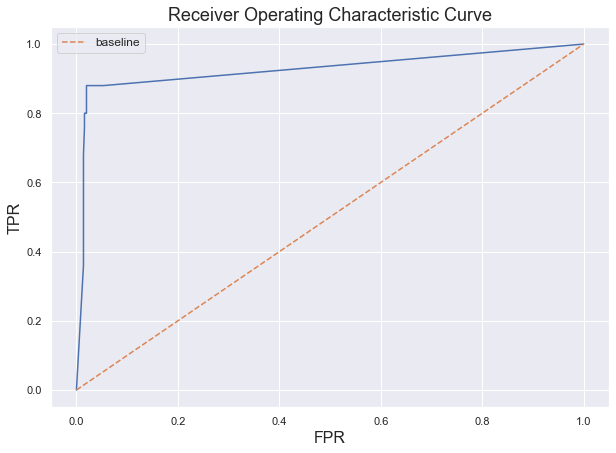

In [19]:
#NN, hyperparameterization shows layer = 10 and max_iter = 1000 is best
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
model = MLPClassifier(hidden_layer_sizes=(10,10,10),max_iter=1000)
model.fit(X_train,y_train.ravel())

#preditions
predictions_training = model.predict(X_train)
predictions_test = model.predict(X_test)
print("Training accuracy of sklearn neural network: {}".format(round(accuracy_score(predictions_training, y_train),2)*100))
print("Test accuracy of sklearn neural network: {}".format(round(accuracy_score(predictions_test, y_test),2)*100))

#look at confusion matrix
print(pd.DataFrame(confusion_matrix(y_test, predictions_test), columns=['Predicted Healthy', "Predicted Disease"], index=['Actual Healthy', 'Actual Disease']))

#ROC
#look at values
tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')
#get probabilities
probas = model.predict_proba(X_test)[:, 1]
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]
#get roc values
roc_values = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tpr_values, fpr_values = zip(*roc_values)
#visualize
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, predictions_test))

Accuracy: 0.8679245283018868
True Positives: 10
False Positives: 55
True Negatives: 450
False Negatives: 15
0.6455445544554456


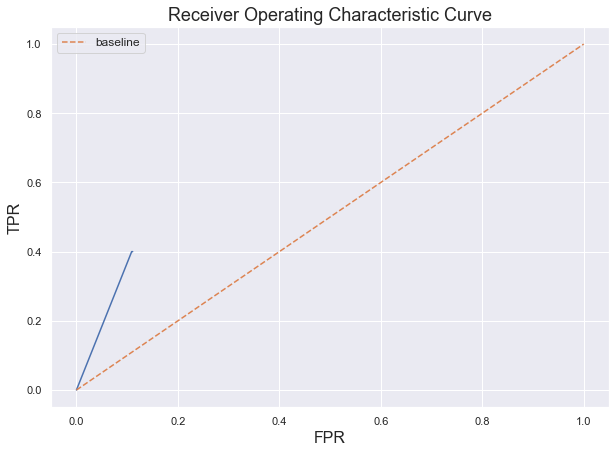

In [17]:
#Naive Bayes 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
model_GNB = GaussianNB()
model_GNB.fit(X_train, y_train.ravel());

y_pred = model_GNB.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

#confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted Healthy', "Predicted Disease"], index=['Actual Healthy', 'Actual Disease'])

#ROC
#look at values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')
#get probabilities
probas = model_GNB.predict_proba(X_test)[:, 1]
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]
#get roc values
roc_values = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tpr_values, fpr_values = zip(*roc_values)
#visualize
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

Accuracy score of Linear SVM, C = 1: 97.9245283018868
                Predicted Healthy  Predicted Disease
Actual Healthy                500                  5
Actual Disease                  6                 19


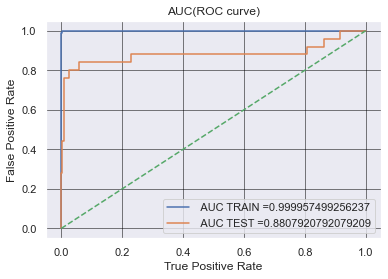

In [20]:
#SVM, hyperparameterization shows that 'C': 100, 'gamma': 0.0001, 'kernel': 'rbf' is best
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

model = SVC(kernel = 'rbf', C = 100, gamma = 0.0001)
model.fit(X_train, y_train.ravel())

#accuracy
y_train_pred = model.decision_function(X_train)    
y_test_pred = model.decision_function(X_test)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)*100 
print("Accuracy score of Linear SVM, C = 1:", accuracy)

#confusion matrix
print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted Healthy', "Predicted Disease"], index=['Actual Healthy', 'Actual Disease']))

#ROC without probabilities
#look at values
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [29]:
#prep for hyperparametization
from sklearn.model_selection import GridSearchCV
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [21]:
#grid search NN
model = MLPClassifier()
param_grid = {
    'hidden_layer_sizes': [3, 5, 10],
    'max_iter': [100,500,1000]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train.ravel(), y_test.ravel(), model, 
                                 param_grid, cv=5, scoring_fit='accuracy')

print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.8min finished


0.9088161827021721
{'hidden_layer_sizes': 10, 'max_iter': 1000}


In [20]:
#grid search SVM
model = SVC()
param_grid = {
    'C': [1,10,100,1000],
    'kernel': ['linear', 'sigmoid', 'rbf'],
    'gamma': [0.001, 0.0001]
}

model, pred = algorithm_pipeline(X_train, X_test, y_train.ravel(), y_test.ravel(), model, 
                                 param_grid, cv=5, scoring_fit='accuracy')

print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.6min finished


0.9645680003568401
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}


In [51]:
#cross validation of parameter optimized SVM
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

k = 10
kf = KFold(n_splits=k, shuffle=True)
model = SVC(kernel = 'rbf', C = 100, gamma = 0.0001)
 
result = cross_val_score(model, X, y.ravel(), cv = kf)
 
print("Avg accuracy of SVM: {}".format(result.mean()))

Avg accuracy of SVM: 0.9667510005717552


In [73]:
#cross validation of parameter optimized NN
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

k = 10
kf = KFold(n_splits=k, shuffle=True)
model = MLPClassifier(hidden_layer_sizes=(10,10,10),max_iter=1000)
 
result = cross_val_score(model, X, y.ravel(), cv = kf)
 
print("Avg accuracy of NN: {}".format(result.mean()))

Avg accuracy of NN: 0.9599585477415665


In [74]:
#cross validation of GNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

k = 10
kf = KFold(n_splits=k, shuffle=True)
model = GaussianNB()
 
result = cross_val_score(model, X, y.ravel(), cv = kf)
 
print("Avg accuracy of GNB: {}".format(result.mean()))

Avg accuracy of GNB: 0.836014865637507


In [ ]:
#identify important bacteria
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train,y_train.ravel())
print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.savefig("subset_feature_importance.png")

In [37]:
#prep for association rules, difficult due to dataset size, renaming of bacteria required
#fix column names
subset.columns = strip.columns.str.strip().str.lower().str.replace(' ','').str.replace('(','').str.replace(')','')

#resubset significantly to reduce run time
indexed = subset.sample(3)#random small subset
indexed = subset.sample(10, axis = 'columns')#random small subset

#melt data for expected format by apyori
indexed = pd.melt(indexed, id_vars = ['sampleID'])
indexed.head(10)

#test list
records = []
for i in range(0, subset.shape[0]):
    records.append([str(subset.values[i,j]) for j in range(0, subset.shape[1])])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [26]:
#calculate association rules
association_rules = apriori(records, min_support=0.01, min_confidence=0.2, min_lift=3, min_length=2)
association_results = list(association_rules)
print(len(association_results))

306


In [28]:
#print all association rules
for item in association_results:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: 0.00143 -> 0.29936
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.00217 -> 0.0539
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.00217 -> 0.14981
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.00535 -> 0.00349
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.00349 -> 0.00586
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.00349 -> 0.02204
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.00349 -> 0.03646
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.21589 -> 0.00349
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.20281 -> 0.00451
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 1.42472 -> 0.00451
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.23142 -> 0.00465
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.00535 -> 0.00586
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.00535 -> 0.02204
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.00535 -> 0.03646
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.00535 -> 0.21589
Support: 0.02
Confidence: 1.0
Lift: 50.0
Rule: 0.022